<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Web APIs & NLP  
## PART 2/2: Problem Statement, Data Cleaning, EDA, Modelling

-------

## Project Statement:

**The client**: An education consultancy who works with prospective undergraduates choosing a college major. The client would like to focus on students wishing to help people with their health, but do not necessarily intend to take up Medicine or Nursing as a major. 

**Task**: 

- Prepare a NLP study of the two topics: "Physiotherapy" and "Chiropractic" based on two Subreddit threads. 

**Objectives of the study**:
1) Optimize a classifier model that can successfully categorize unlabelled Subreddit posts into one of the two groups. The best model will be evaluated based on Accuracy and ROC AUC Score. 
2) Compare and contrast between "Physiotherapy" and "Chiropractic" based on model results. 

The results of this study will help prospective undergraduates evaluate if either one of these two fields are a good fit with their aspirations. 


## Background:

A **physiotherapist/physical therapist**, also known as a PT, focuses on improving your ability to move and function without pain which, in turn, helps boost your quality of life.

The goal of PT is for you to achieve the highest level of movement possible to function in daily life.

PTs evaluate patients and guide them in stretches and exercises, and educate them on ways to stay active and healthy.

**Chiropractors** are licensed professionals with doctorate degrees who use a hands-on approach to ease pain and inflammation by manipulating parts of the body (mainly by adjusting the spine).

The philosophy behind chiropractic care is that your body can heal itself with interventions performed by a chiropractor.

Basically, chiro and physio can treat spinal joint and muscles problem to reduce pain, increase movement and flexibility. Both treat a number of different but similar neuromusculoskeletal conditions including headaches, migraines, back and neck pain, sports injuries, sciatica, scoliosis, disc degeneration. 

**For students interested to pursue either one of these two alternative healthcare professions:** You will need a Bachelor’s Degree or even a Masters to be a Physiotherapist. Chiros are not medical doctors, but graduate with a Doctor of Chiropractic Degree. In the context of Singapore, Physios are employed in both the public and private sector, but chiropractors can only work in a private setting. 

**Sources:** [Healthline](https://www.healthline.com/health/physiotherapist-vs-chiropractor#about-chiropractic-care) and [heal360 PhysioClinic, Singapore](https://physioclinic.sg/physiotherapy-or-chiropractor-in-singapore/)


## Workflow:

0) Data Scraping (in separate notebook)
1) Data import and cleaning
2) Preprocessing
3) Exploratory Data Analysis (EDA)
4) Hypothesis Testing
5) Modelling:
    - Logistic Regression Model
    - Naive Bayes + Count Vectorizer
    - Naive Bayes + TFIDF Vectorizer
    - Random Forest + Count Vectorizer
6) Conclusion
7) Proposed Future Improvements

## 1. Data Import and Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup 
from nltk.corpus import stopwords # Stopword list
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_roc_curve, roc_auc_score, RocCurveDisplay

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier


In [2]:
physio = pd.read_csv("../dataset/Physiotherapy.csv",index_col = [0])
chiro = pd.read_csv("../dataset/Chiropractic.csv",index_col = [0])


In [3]:
physio.head()

,subreddit,selftext,title
0,physiotherapy,"Hi,\n\nI graduated from physio at the start of...",Private Practice to Aged Care Physio - Sydney
1,physiotherapy,"Hi everyone, I am interested to migrate to Can...",Which to do first PCE or express entry?
2,physiotherapy,"I'm 380 lb, not too tall, male, three years o...",Please recommend me a muscle rehab machine.
3,physiotherapy,I recently graduated from high school and had ...,High school grad looking forward to be a physi...
4,physiotherapy,"Hello All,\n\n\n\nJust want to state before we...",PCE exam attempts ( Canada )


In [4]:
chiro.head()

,subreddit,selftext,title
0,Chiropractic,NaN,Has anyone actually reversed their straight or...
1,Chiropractic,[removed],Knee/Neck Pain Treatment in Delhi
2,Chiropractic,I’m a international student from Hong Kong and...,How is the reputation of Mctimoney college of ...
3,Chiropractic,"Hi, I found a chiropractor in my area, who doe...",Nasal Specific
4,Chiropractic,So this is an update of sorts from my last pos...,Neck problems post-adjustment


### 1.1 Check for null values

In [5]:
print("physio")
print("-------")
print(physio.isnull().sum())
print("chiro")
print("-------")
print(chiro.isnull().sum())

physio
-------
subreddit      0
selftext     228
title          0
dtype: int64
chiro
-------
subreddit      0
selftext     484
title          0
dtype: int64


**Management of null values:**  
We will combine "selftext" and "title" fields into one column for the purpose of NLP. If "selftext" is null, will refer to text in "title" only. Therefore, it is unnecessary to delete rows with null "selftext" values. 

### 1.2 Delete rows where "selftext" is either [removed] or [deleted]

Will delete rows where selftext is [removed] or [deleted] as it may indicate some problems with the submissions. 

In [6]:
for df in [physio,chiro]:
    print(df["subreddit"].value_counts().index)
    print(df["selftext"].value_counts().sort_values(ascending=False)[0:2])

Index(['physiotherapy'], dtype='object')
[removed]    56
[deleted]     4
Name: selftext, dtype: int64
Index(['Chiropractic'], dtype='object')
[removed]    58
[deleted]     3
Name: selftext, dtype: int64


In [7]:
for df in [physio,chiro]:
    print(df["subreddit"].value_counts().index)
    print(f"Before: {df.shape}")
    drop_index = df.loc[(df["selftext"]=="[removed]")|
                        (df["selftext"]=="[deleted]"),:].index
    df.drop(labels=drop_index,inplace=True)
    print(f"rows dropped: {len(drop_index)}")
    print(f"After: {df.shape}")

Index(['physiotherapy'], dtype='object')
Before: (1499, 3)
rows dropped: 60
After: (1439, 3)
Index(['Chiropractic'], dtype='object')
Before: (1500, 3)
rows dropped: 61
After: (1439, 3)


### 1.3 Drop Duplicate Rows

In [8]:
physio["title"].value_counts().sort_values(ascending=False)[0:13]

Name                                                                          4
cross post from r/RedSmileGroup :-)                                           3
Functional anatomy in gait                                                    2
Question for physiotherapists                                                 2
What does this Sub think about this kind of information still going around    2
Student pathways                                                              2
Cost of Massage therapy in Ottawa Physiotherapy Clinic?                       2
Binovi Announces CAVT-VERA-Binovi Connect Integration                         2
کلینیک فیزیوتراپی سایا - کلینیک فیزیوتراپی سایا                               2
Physiotherapy Work                                                            2
PCE exam attempts ( Canada )                                                  1
HI                                                                            1
Physiotherapy recommendation for radius 

In [9]:
physio.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=True)

physio["title"].value_counts().sort_values(ascending=False)[0:13]

Name                                                                                  3
Student pathways                                                                      2
Physiotherapy Work                                                                    2
Question for physiotherapists                                                         2
What does this Sub think about this kind of information still going around            2
As a physio, what is the best things about your job and what are the worst things?    1
Please recommend me a muscle rehab machine.                                           1
High school grad looking forward to be a physiotherapist in Canada                    1
PCE exam attempts ( Canada )                                                          1
Chances of Getting in PT School in Canada                                             1
Physiotherapy recommendation for radius head fracture?                                1
HI                              

We have deleted most of the duplicates except for the top 6 above. These entries have duplicated "titles" but different "selftext". 

In [10]:
physio_repeats = physio.loc[(physio["title"]=="Name")|
                            (physio["title"]=="Physiotherapy Work")|
                            (physio["title"]=="Question for physiotherapists")|
                            (physio["title"]=="Student pathways")|
                            (physio["title"]=="What does this Sub think about this kind of information still going around"),:]

physio_repeats

,subreddit,selftext,title
480,physiotherapy,"Hi,\n\nI'm a UK-based writer, mental health wo...",Question for physiotherapists
756,physiotherapy,I’m from Australia. I have a diploma in nutrit...,Student pathways
757,physiotherapy,I have completed a diploma of nutrition (which...,Student pathways
820,physiotherapy,I am not looking g for a diagnosis nor am I lo...,Question for physiotherapists
858,physiotherapy,"Hi Everyone,\n\nHope all of you doing well, I...",Name
859,physiotherapy,"\n\nHi Everyone,\n\nHope all of you doing wel...",Name
860,physiotherapy,"Hi Everyone,\n\nHope all of you doing well, I ...",Name
1024,physiotherapy,I am researching about what a Physiotherapy do...,Physiotherapy Work
1029,physiotherapy,I have watched Physiotherapist assessing and g...,Physiotherapy Work
1187,physiotherapy,NaN,What does this Sub think about this kind of in...


Based on above, will keep index **480,756,757,820,1024,1029** because they look different.

Index **1187** should be deleted, because the title alone does not give much info.

Will also try to zoom into index **858,859,860** to determine if they are the same.

In [11]:
physio.drop(labels = 1187,inplace=True)

physio_repeats = physio.loc[(physio["title"]=="Name")|
                            (physio["title"]=="Physiotherapy Work")|
                            (physio["title"]=="Question for physiotherapists")|
                            (physio["title"]=="Student pathways")|
                            (physio["title"]=="What does this Sub think about this kind of information still going around"),:]

physio_repeats

,subreddit,selftext,title
480,physiotherapy,"Hi,\n\nI'm a UK-based writer, mental health wo...",Question for physiotherapists
756,physiotherapy,I’m from Australia. I have a diploma in nutrit...,Student pathways
757,physiotherapy,I have completed a diploma of nutrition (which...,Student pathways
820,physiotherapy,I am not looking g for a diagnosis nor am I lo...,Question for physiotherapists
858,physiotherapy,"Hi Everyone,\n\nHope all of you doing well, I...",Name
859,physiotherapy,"\n\nHi Everyone,\n\nHope all of you doing wel...",Name
860,physiotherapy,"Hi Everyone,\n\nHope all of you doing well, I ...",Name
1024,physiotherapy,I am researching about what a Physiotherapy do...,Physiotherapy Work
1029,physiotherapy,I have watched Physiotherapist assessing and g...,Physiotherapy Work
1188,physiotherapy,How often do you find yourself having to get r...,What does this Sub think about this kind of in...


In [12]:
# double check that selftext in rows 858-860 are the same
index_repeat = [858,859,860]
for text in physio.iloc[index_repeat,1]:
    print(text)

 Hi Everyone,

Hope all of you doing well, I am looking for a name regarding to physiotherapy or rehabilitation center.

I would be grateful if you write me your ideas
 

Hi Everyone,

Hope all of you doing well, I am looking for a name regarding to physiotherapy or rehabilitation center.

I would be grateful if you write me your ideas
Hi Everyone,

Hope all of you doing well, I am looking for a name regarding to physiotherapy or rehabilitation center.

I would be grateful if you write me your ideas


**The 3 rows above appear to be duplicated entries, just slightly different due to '\n'. Will keep the first and delete the rest**


In [13]:
physio.drop(labels=[859,860],inplace=True)
physio["title"].value_counts().sort_values(ascending=False)[0:13]

#We have determined that the top 3 title repeats are valid

Question for physiotherapists                                                                                                                                                                                                                             2
Physiotherapy Work                                                                                                                                                                                                                                        2
Student pathways                                                                                                                                                                                                                                          2
Does "the squeeze" you get at the top of a calf raise matter?                                                                                                                                                                                       

**Next, also identify and drop duplicates in the "chiro" dataset:**

In [14]:
chiro["title"].value_counts().sort_values(ascending=False)[0:31]

Chiropractic Care &amp; Spine Adjustment Denton                                  13
Denton Chiropractic Center                                                       10
Chiropractic Care &amp; Pain Relief Center Denton                                 9
Affordable Chiropractor &amp; Pain Relief Center Denton                           8
Chiropractic Services &amp; Pain Relief Center Denton                             7
Pain Relief Center &amp; Affordable Chiropractor Denton                           7
Spine Adjustment &amp; Chiropractic Care Denton                                   6
Chiropractic Services &amp; Neck Pain Relief Center Denton                        5
Spine Adjustment &amp; Affordable Chiropractor Denton                             5
Chiropractic Services &amp; Spine Adjustment Denton                               5
Chiropractic Care &amp; Neck Pain Relief Center Denton                            5
Affordable Chiropractor &amp; Spine Adjustment Denton                       

In [15]:
chiro.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=True)

chiro["title"].value_counts().sort_values(ascending=False)[0:6]

Thoughts?                                                   2
Any burning ideas?                                          2
Guide to Improving Your Posture | Unity Spine and Health    2
Scar tissue                                                 2
Nasal Specific                                              1
Henry Winsor studies?                                       1
Name: title, dtype: int64

In [16]:
chiro_repeats = chiro.loc[(chiro["title"]=="Guide to Improving Your Posture | Unity Spine and Health")|
                          (chiro["title"]=="Any burning ideas?")|
                          (chiro["title"]=="Thoughts?")|
                          (chiro["title"]=="Scar tissue"),:]

chiro_repeats

,subreddit,selftext,title
174,Chiropractic,Can severe and internal scar tissue be resolve...,Scar tissue
175,Chiropractic,NaN,Scar tissue
432,Chiropractic,As a final year chiropractic student I'm about...,Any burning ideas?
433,Chiropractic,NaN,Any burning ideas?
941,Chiropractic,If a chiropractor is told to not adjust a pati...,Thoughts?
1187,Chiropractic,NaN,Thoughts?
1267,Chiropractic,## What causes poor posture?\n\nConditions whi...,Guide to Improving Your Posture | Unity Spine ...
1268,Chiropractic,\n\n## What causes poor posture?\n\nCondition...,Guide to Improving Your Posture | Unity Spine ...


In [17]:
for text in chiro.iloc[[1267,1268],1]:
    print(text)
    print("-----")

## What causes poor posture?

Conditions which impair one or more of the body's supporting structures, such as the spine, back muscles, hips, shoulders, neck and abdominal wall, can also create posture issues.

People with hereditary disorders that impact the curvature of the spine and hips can correct posture from birth in some situations. Such problems can be addressed to reduce the negative impact on posture which they can have over time. In some situations, injuries sustained while participating in sports or other activities might change posture, as the body attempts to protect itself from further injuries (such as limping when your foot is injured).

Our posture often changes due to our work or other activities which cause misuse of various body parts. Underuse can be a concern as well. Weak back muscles on either side of the spine, or weak abdominal wall muscles in front of our bodies, for example, might make it difficult to maintain excellent posture.

Many people's muscles and 

Will delete index **175,433,1187** because selftext is null. Will delete **1267** because it looks very similar to 1268

In [18]:
chiro.drop(labels = [175,433,1187,1267],inplace=True)

chiro["title"].value_counts().sort_values(ascending=False)[0:6]

Has anyone actually reversed their straight or military neck?    1
EB docs, how do you market to gen pop?                           1
Neck problems post-adjustment                                    1
Henry Winsor studies?                                            1
Croft Guidelines for Whiplash Associated Disorder                1
numb spot in back                                                1
Name: title, dtype: int64

In [19]:
physio.shape

(1429, 3)

In [20]:
chiro.shape

(1332, 3)

### 1.4 Combine "physio" and "chiro" datasets into one DataFrame

Will concat both files, and process together.
In order to increase the amount of text available for analysis, will combine title and selftext columns

In [21]:
pc = pd.concat([chiro,physio], ignore_index = True)
pc.head()

,subreddit,selftext,title
0,Chiropractic,NaN,Has anyone actually reversed their straight or...
1,Chiropractic,I’m a international student from Hong Kong and...,How is the reputation of Mctimoney college of ...
2,Chiropractic,"Hi, I found a chiropractor in my area, who doe...",Nasal Specific
3,Chiropractic,So this is an update of sorts from my last pos...,Neck problems post-adjustment
4,Chiropractic,"A chiro gave me literature on the ""Henry Winso...",Henry Winsor studies?


In [22]:
pc.iloc[1330:1335,:]

,subreddit,selftext,title
1330,Chiropractic,Hi! If this isn't the right place to post this...,Question about S-curve neck cause
1331,Chiropractic,"Hello, I have neck issues that leads to tingle...","Neck manipulations , are they safe?"
1332,physiotherapy,"Hi,\n\nI graduated from physio at the start of...",Private Practice to Aged Care Physio - Sydney
1333,physiotherapy,"Hi everyone, I am interested to migrate to Can...",Which to do first PCE or express entry?
1334,physiotherapy,"I'm 380 lb, not too tall, male, three years o...",Please recommend me a muscle rehab machine.


In [23]:
pc.loc[pc["selftext"].notnull(),["alltext"]] = pc["selftext"]+pc["title"]

pc.loc[pc["alltext"].isnull(),["alltext"]] = pc["title"]

       
pc.head()

,subreddit,selftext,title,alltext
0,Chiropractic,NaN,Has anyone actually reversed their straight or...,Has anyone actually reversed their straight or...
1,Chiropractic,I’m a international student from Hong Kong and...,How is the reputation of Mctimoney college of ...,I’m a international student from Hong Kong and...
2,Chiropractic,"Hi, I found a chiropractor in my area, who doe...",Nasal Specific,"Hi, I found a chiropractor in my area, who doe..."
3,Chiropractic,So this is an update of sorts from my last pos...,Neck problems post-adjustment,So this is an update of sorts from my last pos...
4,Chiropractic,"A chiro gave me literature on the ""Henry Winso...",Henry Winsor studies?,"A chiro gave me literature on the ""Henry Winso..."


In [24]:
pc.drop(labels = ["selftext","title"], axis = 1, inplace=True)

pc.head()

,subreddit,alltext
0,Chiropractic,Has anyone actually reversed their straight or...
1,Chiropractic,I’m a international student from Hong Kong and...
2,Chiropractic,"Hi, I found a chiropractor in my area, who doe..."
3,Chiropractic,So this is an update of sorts from my last pos...
4,Chiropractic,"A chiro gave me literature on the ""Henry Winso..."


In [25]:
pc.reset_index(inplace=True,drop=True)
pc.head()

,subreddit,alltext
0,Chiropractic,Has anyone actually reversed their straight or...
1,Chiropractic,I’m a international student from Hong Kong and...
2,Chiropractic,"Hi, I found a chiropractor in my area, who doe..."
3,Chiropractic,So this is an update of sorts from my last pos...
4,Chiropractic,"A chiro gave me literature on the ""Henry Winso..."


In [26]:
pc["subreddit"].value_counts(normalize=True)

physiotherapy    0.517566
Chiropractic     0.482434
Name: subreddit, dtype: float64

### 1.5 Convert "subreddit" into 1/0. 

Subreddit: 1 will refer to Physiotherapy, whereas 0 will refer to Chiropractic

In [27]:
pc["subreddit"] = pc["subreddit"].map({"Chiropractic":0,"physiotherapy":1})

pc.head()

,subreddit,alltext
0,0,Has anyone actually reversed their straight or...
1,0,I’m a international student from Hong Kong and...
2,0,"Hi, I found a chiropractor in my area, who doe..."
3,0,So this is an update of sorts from my last pos...
4,0,"A chiro gave me literature on the ""Henry Winso..."


In [28]:
pc["subreddit"].value_counts(normalize=True)

1    0.517566
0    0.482434
Name: subreddit, dtype: float64

In [29]:
pc["subreddit"].value_counts()

1    1429
0    1332
Name: subreddit, dtype: int64

## 2. Preprocessing

Preprocessing strategy: 
   - Remove HTML code
   - Keep letters only. Ie: will remove all numbers and symbols. 
   - Convert all text to lowercase, to further reduce variability between otherwise similar words
   - Remove stopwords
   - Join the words into a single string
    

### 2.1 Preprocessing Function:

As stemming appeared to have minimal impact on accuracy scores, have decided to just focus on lemmatizing during pre-processing stage

In [30]:
def reddit_to_words(alltext):
    # 1. Remove HTML.
    reddit_text = BeautifulSoup(alltext).get_text()
    
    # 2. Remove non-letters, https, stray HTML code
    letters_only = re.sub("&amp;#x200B;|https:[\S]+|[^a-zA-Z]"," ", alltext) 
    
    # 2.1 Alternative Code to also remove all variations of the words "physio-" and "chiro-":
    # letters_only = re.sub("&amp;#x200B;|https:[\S]+|[^a-zA-Z]|[Pp]hysi[\S]+|[Cc]hir[\S]+"," ", alltext) 
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 4. Convert the stopwords to a set.
    to_remove = set(stopwords.words('english'))
    
    # 5. Remove stopwords and lemmatize
    lemmatizer = WordNetLemmatizer()
    meaningful_words = [lemmatizer.lemmatize(w) for w in words if not w in set(to_remove)]
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [31]:
pc["clean_text"] = pc["alltext"].map(reddit_to_words)

/Users/kenneththesheep/opt/anaconda3/envs/dsi30/lib/python3.8/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/Users/kenneththesheep/opt/anaconda3/envs/dsi30/lib/python3.8/site-packages/bs4/__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [32]:
#for the purpose of EDA 
def reddit_to_words_with_stopwords(alltext):
    reddit_text = BeautifulSoup(alltext).get_text()
    
    letters_only = re.sub("&amp;#x200B;|https:[\S]+|[^a-zA-Z]", " ", alltext)
    
    words = letters_only.lower().split()
    
    lemmatizer = WordNetLemmatizer()
    meaningful_words = [lemmatizer.lemmatize(w) for w in words] 

    return(" ".join(meaningful_words))

In [33]:
pc["clean_text_with_stopwords"] = pc["alltext"].map(reddit_to_words_with_stopwords)

/Users/kenneththesheep/opt/anaconda3/envs/dsi30/lib/python3.8/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/Users/kenneththesheep/opt/anaconda3/envs/dsi30/lib/python3.8/site-packages/bs4/__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


### 2.2 Check if text was cleaned up sufficiently

In [34]:
url_rows = [i for i,text in enumerate(pc["alltext"]) if "http" in text]

Technically, BeautifulSoup should have removed most HTML code, but upon first check, there were some leftover code. Hence, I rewrote the regex code in the function above to manually remove "&amp;#x200B;" as well. 

In [35]:
amp_rows = [i for i,text in enumerate(pc["alltext"]) if "&amp;#x200B;" in text]

In [36]:
# CHECK:
pc.iloc[url_rows,:]

,subreddit,alltext,clean_text,clean_text_with_stopwords
17,0,Opinions?\n\n&amp;#x200B;\n\n[https://people.c...,opinion college graduate paralyzed visit chiro...,opinion college graduate paralyzed after visit...
18,0,I think there are a lot of folks finding quick...,think lot folk finding quick fix back pain aro...,i think there are a lot of folk finding quick ...
37,0,"Here's the link to the article, opens in Scien...",link article open science dot org sfw may chan...,here s the link to the article open in science...
58,0,&amp;#x200B;\n\nhttps://preview.redd.it/0lie33...,prob face patient like time tip learned increa...,you prob face patient like this all the time h...
60,0,[https://youtu.be/NHMRag6swC0](https://youtu.b...,marketing idea generate monthly,marketing idea how to generate monthly
...,...,...,...,...
2732,1,"I was dealing with severe back pain, I was ask...",dealing severe back pain asked doctor get phys...,i wa dealing with severe back pain i wa asked ...
2733,1,Hi Everyone! \n\nI made this cool platform for...,hi everyone made cool platform physiotherapy c...,hi everyone i made this cool platform for phys...
2746,1,\n\nHey guys I’m a final year physiotherapy st...,hey guy final year physiotherapy student condu...,hey guy i m a final year physiotherapy student...
2750,1,"Hello guys, I’ve been asked a few times in pri...",hello guy asked time private update regarding ...,hello guy i ve been asked a few time in privat...


In [37]:
pc.iloc[58,1]

'&amp;#x200B;\n\nhttps://preview.redd.it/0lie338ir0b91.jpg?width=260&amp;format=pjpg&amp;auto=webp&amp;s=45573d56765425c56291f2ff3758b5385ac7c486\n\nYou prob face patients like this all the time...\n\nHere’s the no.1 tips that I learned to increase patients’ experience\n\nSo they can give you good testimonials, good reviews and refer you to their friends and family.\n\nYou have to treat your patients like a human.\n\nYou get to find find out your patient’s ‘why’,\n\nWhen they first come to your practice, ask them:\n\n‘Before taking your insurance, mind if I ask you a few questions first to see if I can actually help?’\n\nWhy are they here at your clinic? What have they tried? What works? What doesn’t?\n\nWhat’s their goal?\n\nand show them the transformation\n\nShow them how you are going to help them.\n\nShow them how their life will be after you helped achieve their goal.\n\nShow them how you helped people like him to go through the process.\n\nYou don’t just crack their back, their 

In [38]:
pc.iloc[58,2]

'prob face patient like time tip learned increase patient experience give good testimonial good review refer friend family treat patient like human get find find patient first come practice ask taking insurance mind ask question first see actually help clinic tried work goal show transformation show going help show life helped achieve goal show helped people like go process crack back neck treat people fear dream feeling coming chiro get rid knee pain go back cross fit coming way crossfit make feel want go back crossfit play sport like make feel good able treat patient like human make feel like treated like human cash generating tool start seeing referral coming practice wish knew even start chiro practice'

In [39]:
pc.iloc[amp_rows,:]

,subreddit,alltext,clean_text,clean_text_with_stopwords
17,0,Opinions?\n\n&amp;#x200B;\n\n[https://people.c...,opinion college graduate paralyzed visit chiro...,opinion college graduate paralyzed after visit...
18,0,I think there are a lot of folks finding quick...,think lot folk finding quick fix back pain aro...,i think there are a lot of folk finding quick ...
58,0,&amp;#x200B;\n\nhttps://preview.redd.it/0lie33...,prob face patient like time tip learned increa...,you prob face patient like this all the time h...
99,0,&amp;#x200B;\n\nhttps://preview.redd.it/n6r7lo...,good mobility decreased mobility effect range ...,good mobility decreased mobility can effect th...
111,0,I started seeing a local Chiro in march of 202...,started seeing local chiro march neck pain ove...,i started seeing a local chiro in march of for...
...,...,...,...,...
2603,1,**Hi Physiotherapists and friends!**\n\n&amp;#...,hi physiotherapist friend quick question looki...,hi physiotherapist and friend quick question j...
2645,1,"Hey guys, just wondering what anyones tips are...",hey guy wondering anyones tip prior commencing...,hey guy just wondering what anyones tip are pr...
2689,1,Hi all - just wanted to get opinions on clinic...,hi wanted get opinion clinic ownership clinic ...,hi all just wanted to get opinion on clinic ow...
2750,1,"Hello guys, I’ve been asked a few times in pri...",hello guy asked time private update regarding ...,hello guy i ve been asked a few time in privat...


### 2.3 Delete rows with no text left after preprocessing

In [40]:
pc["new_chara_count"] = pc["clean_text"].map(lambda x:len(x))
pc["new_word_count"] = pc["clean_text"].map(lambda x:len([word for word in x.split(" ")]))
pc.sort_values("new_chara_count",ascending=True)[0:20]

,subreddit,alltext,clean_text,clean_text_with_stopwords,new_chara_count,new_word_count
1843,1,کلینیک فیزیوتراپی,,,0,1
1662,1,بهترین کلینیک فیزیوتراپی در گاندی,,,0,1
1842,1,فوق تخصص مغز و اعصاب,,,0,1
1685,1,کلینیک فیزیوتراپی سایا - کلینیک فیزیوتراپی سایا,,,0,1
1586,1,https://www.reddit.com/r/orthotropics/comments...,,,0,1
1949,1,https://tpr-pain-relief-nirvana-for.kckb.st/re...,,,0,1
22,0,What does this mean and what can I do about it?,mean,what doe this mean and what can i do about it,4,1
294,0,HOW CRAZY!?!?!?!?!,crazy,how crazy,5,1
1536,1,What do you think this is?,think,what do you think this is,5,1
2264,1,Do I have bowlegs ?,bowleg,do i have bowleg,6,1


In [41]:
#will delete any new_chara_count that is 0
print(f"before: {pc.shape}")
zero_chara_count = pc.loc[pc["new_chara_count"]==0,:].index
pc.drop(labels = zero_chara_count,inplace=True)
print(f"after: {pc.shape}")

before: (2761, 6)
after: (2755, 6)


### 2.4 Delete rows that are duplicated after pre-processing

In [42]:
pc.sort_values("new_word_count",ascending=True)[0:20]

,subreddit,alltext,clean_text,clean_text_with_stopwords,new_chara_count,new_word_count
441,0,Discuss,discus,discus,6,1
1536,1,What do you think this is?,think,what do you think this is,5,1
22,0,What does this mean and what can I do about it?,mean,what doe this mean and what can i do about it,4,1
2263,1,Maderotherapy,maderotherapy,maderotherapy,13,1
2264,1,Do I have bowlegs ?,bowleg,do i have bowleg,6,1
294,0,HOW CRAZY!?!?!?!?!,crazy,how crazy,5,1
1841,1,Can anybody tell me what this is?,anybody tell,can anybody tell me what this is,12,2
1775,1,Physiotherapists and Physiotherapy,physiotherapist physiotherapy,physiotherapist and physiotherapy,29,2
1021,0,Do we know everything?,know everything,do we know everything,15,2
2496,1,Thoughts on this question,thought question,thought on this question,16,2


In [43]:
#will delete clean_text that is duplicated
print(f"before: {pc.shape}")
pc.drop_duplicates(subset="clean_text", keep='first', inplace=True, ignore_index=True)
print(f"after: {pc.shape}")

before: (2755, 6)
after: (2748, 6)


### 2.5 Delete rows with only 1 word left after pre-processing, and does not appear to be of significance to the topic(s)

In [44]:
# Check if "bowlegs" is in any other observation, if not, it is an outlier, and will be deleted
[pc.iloc[i,:] for i,text in enumerate(pc["clean_text"]) if "bowleg" in text]

[subreddit                                      1
 alltext                      Do I have bowlegs ?
 clean_text                                bowleg
 clean_text_with_stopwords       do i have bowleg
 new_chara_count                                6
 new_word_count                                 1
 Name: 2251, dtype: object]

In [45]:
[pc.iloc[i,:] for i,text in enumerate(pc["clean_text"]) if "madero" in text]

[subreddit                                1
 alltext                      Maderotherapy
 clean_text                   maderotherapy
 clean_text_with_stopwords    maderotherapy
 new_chara_count                         13
 new_word_count                           1
 Name: 2250, dtype: object]

In [46]:
zero_word_count = pc.loc[pc["new_word_count"]==1,:].index
zero_word_count


Int64Index([22, 293, 438, 1531, 2250, 2251], dtype='int64')

In [47]:
#will delete all new_word_count ==1, since clean_text is either too generalized to give any info, 
#or any special words are just outliers
print(f"before: {pc.shape}")
pc.drop(labels=[22, 293, 438, 1531, 2250, 2251], inplace=True)
pc.reset_index(inplace=True,drop=True)
print(f"after: {pc.shape}")

before: (2748, 6)
after: (2742, 6)


In [48]:
pc.sort_values("new_word_count",ascending=True)[:10]

,subreddit,alltext,clean_text,clean_text_with_stopwords,new_chara_count,new_word_count
1827,1,Can anybody tell me what this is?,anybody tell,can anybody tell me what this is,12,2
2493,1,Physio Circle,physio circle,physio circle,13,2
644,0,How accurate is this infographic?,accurate infographic,how accurate is this infographic,20,2
1690,1,Can I have a translation please :-),translation please,can i have a translation please,18,2
536,0,United we stand,united stand,united we stand,12,2
2307,1,Physiotherapy Brampton,physiotherapy brampton,physiotherapy brampton,22,2
1356,1,Any Physiotherapist from Bahrain?,physiotherapist bahrain,any physiotherapist from bahrain,23,2
1065,0,What’s this called and is it fixable?,called fixable,what s this called and is it fixable,14,2
496,0,Why has this become a thing?,become thing,why ha this become a thing,12,2
131,0,Would you adjust it? 🧐,would adjust,would you adjust it,12,2


In [49]:
pc.sort_values("new_word_count",ascending=False)[:5]

,subreddit,alltext,clean_text,clean_text_with_stopwords,new_chara_count,new_word_count
2731,1,"Hello guys, I’ve been asked a few times in pri...",hello guy asked time private update regarding ...,hello guy i ve been asked a few time in privat...,4009,554
2528,1,Sorry in Advance for the long post.\n\nTL;DR:...,sorry advance long post tl dr dicked around me...,sorry in advance for the long post tl dr been ...,3750,533
1013,0,There's a lot to cover here... but I'm gonna t...,lot cover gonna try make short point unbias mu...,there s a lot to cover here but i m gonna try ...,3402,519
1010,0,I was asked my advice on reaching out to local...,asked advice reaching local business decided s...,i wa asked my advice on reaching out to local ...,3079,473
192,0,Hello folks! I wrote about a month ago when I ...,hello folk wrote month ago month seeing chirop...,hello folk i wrote about a month ago when i wa...,3131,454


## 3. Exploratory Data Analysis (EDA)

### 3.1 Overall distribution of characters and words in the dataset

In [50]:
ctwsw = "clean_text_with_stopwords"

In [51]:
pc["chara_count"] = pc[ctwsw].map(lambda x:len(x))
pc["word_count"] = pc[ctwsw].map(lambda x:len([i for i in x.split(" ")]))
                                      

In [52]:
x1 = "chara_count"
x2 = "new_chara_count"
title_1 = "Distribution of Character Count per post with stopwords"
title_2 = "Distribution of Character Count per post without stopwords"
xlim_max = 2500

def dist_plot(x1,x2,title_1,title_2,xlim_max):
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, 
                             squeeze=True, figsize=(18,8), constrained_layout=True)
    axes = axes.ravel()

    sns.set(style="whitegrid")

    sns.histplot(data=pc, x=x1, hue = "subreddit", 
                 kde=True, ax=axes[0])
    axes[0].axvline(pc[x1].mean()+(3*pc[x1].std()), 
                    color='red',linestyle=':', linewidth=2,label='stddev')
    axes[0].axvline(pc[x1].median(), color='blue', linestyle='dashed', linewidth=3, label='median')
    axes[0].axvline(pc[x1].mean(), color='black', linewidth=3, label='mean')
    axes[0].set_title(title_1,
                      fontsize=18,fontweight="heavy",pad=10)
    axes[0].set_xlim(0,xlim_max)

    sns.histplot(data=pc, x=x2, hue = "subreddit", 
                 kde=True, ax=axes[1])
    axes[1].axvline(pc[x2].mean()+(3*pc[x2].std()), 
                    color='red',linestyle=':',linewidth=2, label='stddev')
    axes[1].axvline(pc[x2].median(), 
                    color='blue', linestyle='dashed', linewidth=3, label='median')
    axes[1].axvline(pc[x2].mean(), color='black', linewidth=3, label='mean')

    axes[1].set_title(title_2,
                      fontsize=18,fontweight="heavy",pad=10);
    return

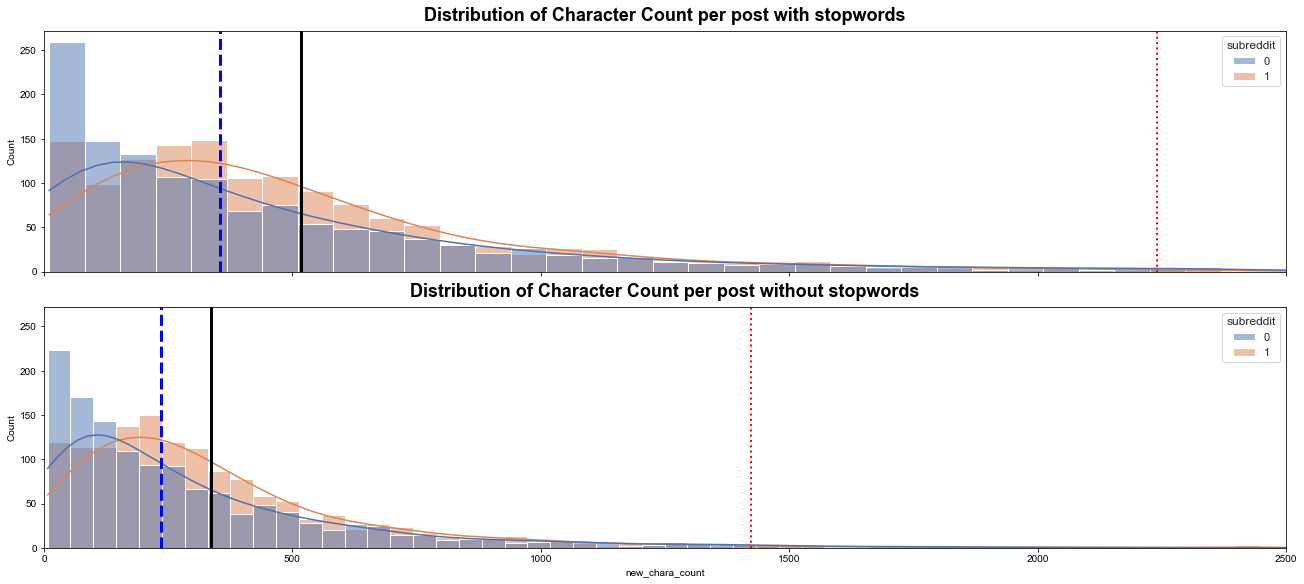

In [53]:
dist_plot(x1,x2,title_1,title_2,xlim_max)

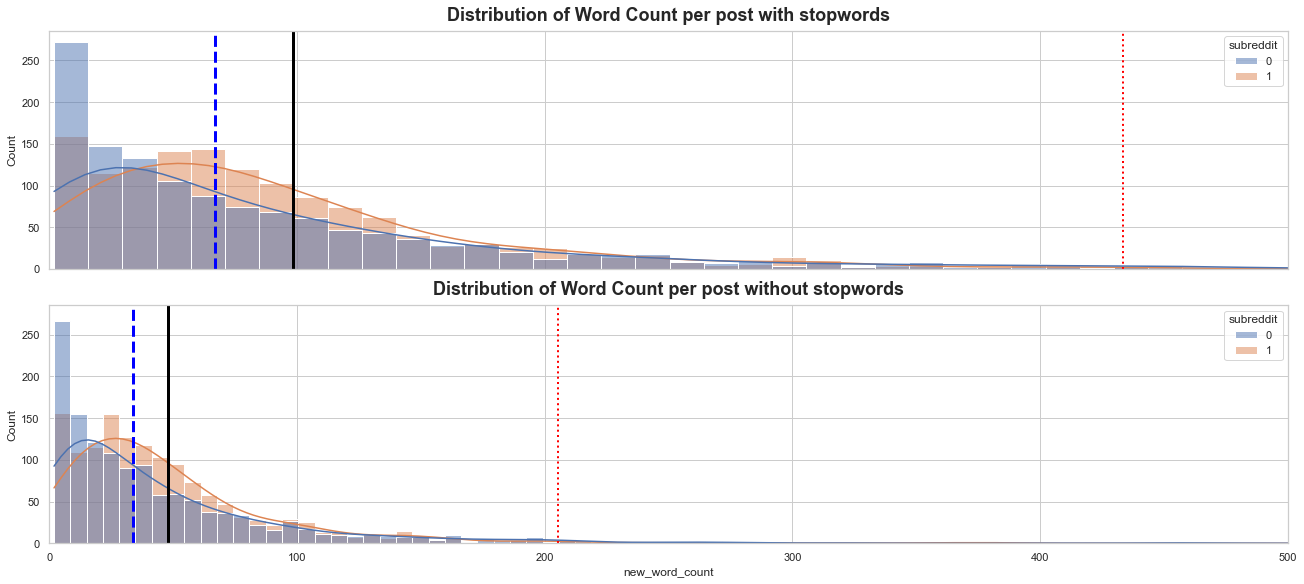

In [54]:
x1 = "word_count"
x2 = "new_word_count"
title_1 = "Distribution of Word Count per post with stopwords"
title_2 = "Distribution of Word Count per post without stopwords"
xlim_max = 500

dist_plot(x1,x2,title_1,title_2,xlim_max)

Both "physio" and "chiro" classes have left-skewed distributions of word- and character-counts. It also appears that very short posts are more common in the "Chiropractic" thread vs the "Physiotherapy" thread.

### 3.2 Top occuring words in the combined dataset:

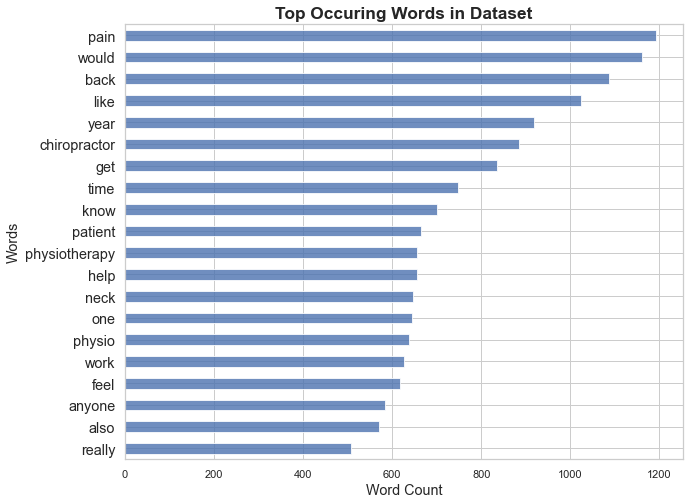

In [55]:
cvec = CountVectorizer()
clean_text_df = pd.DataFrame(cvec.fit_transform(pc["clean_text"]).todense(),columns=cvec.get_feature_names_out())

plt.figure(figsize = (10,8))
clean_text_df.sum().sort_values(ascending=True).tail(20).plot(kind='barh',alpha = 0.8)
plt.yticks(fontsize="large")
plt.xlabel("Word Count",fontsize="large")
plt.ylabel("Words",fontsize="large")
plt.title("Top Occuring Words in Dataset",
          fontsize="x-large",fontweight="heavy");

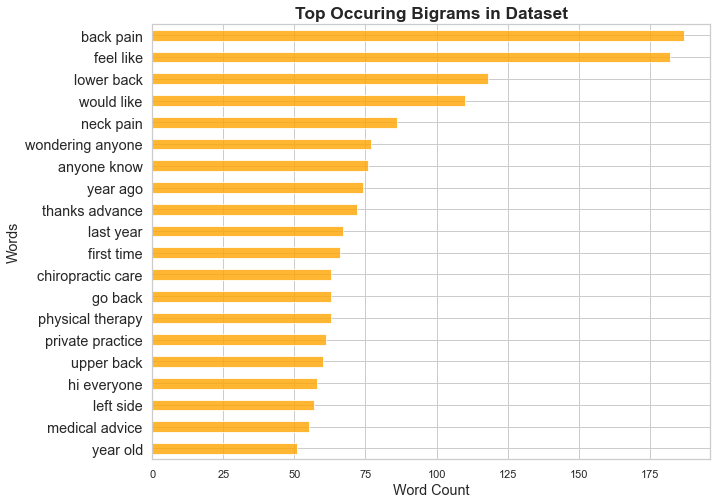

In [56]:
cvec = CountVectorizer(ngram_range= (2, 2))
clean_text_df = pd.DataFrame(cvec.fit_transform(pc["clean_text"]).todense(),columns=cvec.get_feature_names_out())

plt.figure(figsize = (10,8))
clean_text_df.sum().sort_values(ascending=True).tail(20).plot(kind='barh',alpha = 0.8, color = 'orange')
plt.yticks(fontsize="large")
plt.xlabel("Word Count",fontsize="large")
plt.ylabel("Words",fontsize="large")
plt.title("Top Occuring Bigrams in Dataset",
          fontsize="x-large",fontweight="heavy");

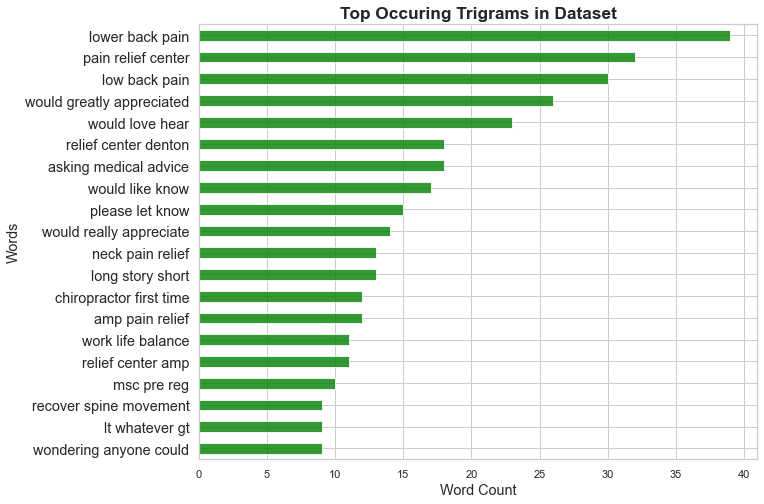

In [57]:
cvec = CountVectorizer(ngram_range= (3, 3))
clean_text_df = pd.DataFrame(cvec.fit_transform(pc["clean_text"]).todense(),columns=cvec.get_feature_names_out())

plt.figure(figsize = (10,8))
clean_text_df.sum().sort_values(ascending=True).tail(20).plot(kind='barh',alpha = 0.8, color='green')
plt.yticks(fontsize="large")
plt.xlabel("Word Count",fontsize="large")
plt.ylabel("Words",fontsize="large")
plt.title("Top Occuring Trigrams in Dataset",
          fontsize="x-large",fontweight="heavy");

The barplot of frequency of trigrams in the dataset indicates a common theme in the two threads, where posting Redditors seek out Physiotherapy and Chiropractic care to treat and relieve lower back pain. 

## 4. Hypothesis Testing

**Null Hypothesis**: There is no significant difference between the probabilities of words occurring between the two classes. 

**Alternative Hypothesis**: There is significant difference between the probabilities of words occuring between the two classes. 

## 5. Modelling

### 5.1 Baseline score

In [58]:
X_train, X_test, y_train, y_test = train_test_split(pc[['clean_text']],
                                                    pc['subreddit'],
                                                    test_size = 0.25,
                                                    random_state = 42,
                                                    stratify = pc['subreddit'])

X_train_l = [a for a in X_train["clean_text"]]
X_test_l = [b for b in X_test["clean_text"]]

In [59]:
y_test.value_counts(normalize=True)

1    0.517493
0    0.482507
Name: subreddit, dtype: float64

**The baseline score is approximately 51.7%.** If we just randomly sampled from the dataset, there is a 51.7% success rate of predicting "Physiotherapy" correctly. 

## Model 1: Logistic Regression and Count Vectorizer

In [60]:
X_train, X_test, y_train, y_test = train_test_split(pc[['clean_text']],
                                                    pc['subreddit'],
                                                    test_size = 0.25,
                                                    random_state = 42,
                                                    stratify = pc['subreddit'])

X_train_l = [a for a in X_train["clean_text"]]
X_test_l = [b for b in X_test["clean_text"]]

### LogReg Model: Setting up Pipelines

In [61]:
pipe_logreg = Pipeline([
    ('cvec',CountVectorizer()), #first step
    ('logreg', LogisticRegression()) #second step
])
    

In [62]:
pipe_logreg.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('logreg', LogisticRegression())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'logreg': LogisticRegression(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'logreg__C': 1.0,
 'logreg__class_weight': None,
 'logreg__dual': False,
 'logreg__fit_intercept': True,
 'logreg__intercept_scaling': 1,
 'logreg__l1_ratio': None,
 'logreg__max_iter': 100,
 'logreg__multi_class': 'auto',
 'logreg__n_jobs': None,
 'logreg__penalty': 'l2',
 'logreg__random_state': None,
 'logreg__solver': 'lbfgs',
 'logreg__tol':

In [63]:
pipe_logreg_params = {'cvec__max_features': [2000], #[3000, 4000, 5000]
                      'cvec__min_df': [1], #[2,3]
                      'cvec__max_df': [0.85], #[0.9,0.95]
                      'cvec__ngram_range': [(1,3)], #[(1,1),(1,2),(2,2),(3,3)]
                      'logreg__solver': ['liblinear'],
                      'logreg__verbose': [1] #[0]
                     }

In [64]:
gs_logreg = GridSearchCV(pipe_logreg, 
                         param_grid = pipe_logreg_params, 
                         cv = 5) 


In [65]:
X_train_l = [a for a in X_train["clean_text"]]
X_test_l = [b for b in X_test["clean_text"]]

In [66]:
gs_logreg.fit(X_train_l,y_train)
gs_logreg.best_score_

[LibLinear]iter  1 act 6.641e+02 pre 5.714e+02 delta 4.674e+00 f 1.140e+03 |g| 6.724e+02 CG   7
cg reaches trust region boundary
iter  2 act 1.887e+02 pre 1.529e+02 delta 6.176e+00 f 4.755e+02 |g| 1.902e+02 CG  10
iter  3 act 6.461e+01 pre 5.161e+01 delta 6.176e+00 f 2.868e+02 |g| 7.413e+01 CG   9
iter  4 act 2.775e+01 pre 2.223e+01 delta 6.176e+00 f 2.222e+02 |g| 3.029e+01 CG  10
iter  5 act 8.764e+00 pre 7.488e+00 delta 6.176e+00 f 1.944e+02 |g| 1.179e+01 CG  11
iter  6 act 1.120e+00 pre 1.018e+00 delta 6.176e+00 f 1.856e+02 |g| 3.695e+00 CG  10
iter  7 act 4.169e-02 pre 4.083e-02 delta 6.176e+00 f 1.845e+02 |g| 7.075e-01 CG  11
iter  8 act 2.180e-04 pre 2.163e-04 delta 6.176e+00 f 1.845e+02 |g| 5.788e-02 CG   9
[LibLinear]iter  1 act 6.782e+02 pre 5.857e+02 delta 5.441e+00 f 1.140e+03 |g| 6.752e+02 CG   8
iter  2 act 1.745e+02 pre 1.416e+02 delta 6.357e+00 f 4.621e+02 |g| 1.889e+02 CG  10
iter  3 act 5.763e+01 pre 4.519e+01 delta 6.357e+00 f 2.876e+02 |g| 7.398e+01 CG   8
iter  4 ac

0.8920251340561738

### LogReg Model: Best Estimators

In [67]:
gs_logreg.best_estimator_[0]

CountVectorizer(max_df=0.85, max_features=2000, ngram_range=(1, 3))

### LogReg Model: Train and Test Scores

In [68]:
print(f"Logistic Regression train score: {gs_logreg.score(X_train_l,y_train)}")
print(f"Logistic Regression test score: {gs_logreg.score(X_test_l,y_test)}")

Logistic Regression train score: 0.9931906614785992
Logistic Regression test score: 0.892128279883382


### LogReg Model: Feature Coefficients

In [69]:
gs_logreg.best_estimator_.steps[0][1].get_feature_names_out()

array(['ability', 'able', 'able help', ..., 'youtube', 'yr', 'zealand'],
      dtype=object)

In [70]:
gs_logreg.best_estimator_.steps[1][1].coef_

array([[-0.19961074, -0.15127999,  0.01945078, ...,  0.11720633,
         0.25036495,  0.00848415]])

In [71]:
log_reg_feat = gs_logreg.best_estimator_.steps[0][1].get_feature_names_out()
log_reg_coef = gs_logreg.best_estimator_.steps[1][1].coef_

logreg_results = pd.DataFrame(log_reg_coef.T,index = log_reg_feat)

In [72]:
logreg_results.columns = ["feature_coef"]

logreg_results.head()

,feature_coef
ability,-0.199611
able,-0.151280
able help,0.019451
abroad,0.231262
absolutely,-0.005350


In [73]:
physio_coef = logreg_results.sort_values(by = "feature_coef",ascending=False)[0:10].index

In [74]:
chiro_coef = logreg_results.sort_values(by = "feature_coef",ascending=True)[0:10].index

In [75]:
top_10_index = [c for c in chiro_coef]+[p for p in physio_coef]

In [76]:
logreg_results.to_csv("../dataset/logreg_results_lammet_only",index= False)

In [77]:
top_10_coef = logreg_results.loc[top_10_index,["feature_coef"]]
top_10_coef

,feature_coef
chiropractic,-2.568470
chiropractor,-2.396391
chiro,-2.081722
adjustment,-1.788025
cmcc,-1.543394
chiros,-1.271285
office,-1.052451
getting,-0.939034
pop,-0.925416
ray,-0.914396


#### Function: likelihood of success

In [78]:
def likelihood(x):
    return np.exp(abs(x))


In [79]:
top_10_coef["likelihood"] = top_10_coef["feature_coef"].map(likelihood)
top_10_coef["subreddit"] = "Chiropractic"
top_10_coef.iloc[10:20,2] = "Physiotherapy"
top_10_coef

,feature_coef,likelihood,subreddit
chiropractic,-2.568470,13.045851,Chiropractic
chiropractor,-2.396391,10.983464,Chiropractic
chiro,-2.081722,8.018261,Chiropractic
adjustment,-1.788025,5.977634,Chiropractic
cmcc,-1.543394,4.680448,Chiropractic
chiros,-1.271285,3.565430,Chiropractic
office,-1.052451,2.864664,Chiropractic
getting,-0.939034,2.557510,Chiropractic
pop,-0.925416,2.522917,Chiropractic
ray,-0.914396,2.495268,Chiropractic


### LogReg Model: Graphical Summary of Top 10 predictor words

In [80]:
color_list_1 = (['red']*10)
color_list_2 = (['blue']*10)

#### Function: bar_plot

In [81]:
top_10 = top_10_coef
metric = "feature_coef"
x_label = "Coefficient"

def bar_plot(top_10,metric,x_label):
    plt.figure(figsize = (10,8))
    plt.barh(top_10.index[-11::-1],top_10[metric][-11::-1],
             alpha=0.5,color = color_list_1,label="Chiro")
    plt.barh(top_10.index[:-11:-1],top_10[metric][:-11:-1],
             alpha=0.5,color = color_list_2,label="Physio")
    plt.legend()

    plt.yticks(fontsize="large")
    plt.xlabel(x_label,fontsize="large")
    plt.ylabel("Words",fontsize="x-large")
    plt.title("Top 10 Words predicting Subreddit categorization",
              fontsize="x-large",fontweight="heavy");

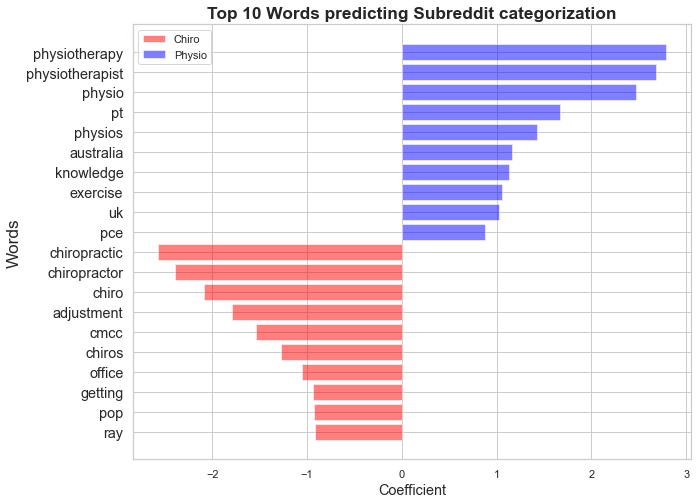

In [82]:
bar_plot(top_10,metric,x_label)

**Comments:**

- Nearly half of each list of the top predictor words consists of some variation of the word "Physio" or "Chiro". To test if the model is sufficiently robust (and still able to classify in the absense of these "obvious" keywords), we could try to add these words to the list of stopwords to remove during the pre-processing stage. 

- Apart from that, this list of top predictor words corroborates our understanding that "exercise" is more relevant to "Physiotherapy", while "adjustment" is more closely related to "Chiropractic". 

- PCE: Physiotherapy Competency Examination. 

- CMCC: Canadian Memorial Chiropractic College



### LogReg Model: Confusion Matrix & Performance Metrics

In [83]:
log_reg_predict = gs_logreg.predict(X_test_l)

#### Function: plot_confusion_matrix

LogReg Model
------
True Negatives: 293
False Positives: 38
False Negatives: 36
True Positives: 319
-------
Accuracy = 0.892128279883382
Specificity = 0.8851963746223565
Sensitivity = 0.8985915492957747
Precision = 0.8935574229691877
--------


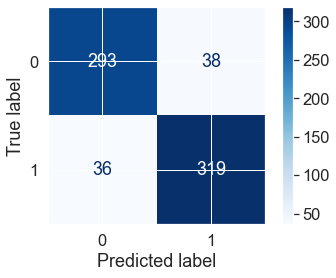

In [84]:
predict = log_reg_predict
color = "Blues"
model_name = "LogReg Model"

def plot_confusion_matrix(model_name,predict,color):
    cm = confusion_matrix(y_test,predict)
    tn, fp, fn, tp = confusion_matrix(y_test, predict).ravel()
    print(model_name)
    print("------")
    print("True Negatives: %s" % tn)
    print("False Positives: %s" % fp)
    print("False Negatives: %s" % fn)
    print("True Positives: %s" % tp)
    disp = ConfusionMatrixDisplay(cm)
    sns.set(font_scale=1.5)
    disp.plot(cmap=color,values_format='d');
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    print("-------")
    print(f"Accuracy = {accuracy}")
    specificity = tn/(tn+fp)
    print(f"Specificity = {specificity}")
    sensitivity = tp/(tp+fn)
    print(f"Sensitivity = {sensitivity}") 
    precision = tp/(tp+fp)
    print(f"Precision = {precision}")
    print("--------")
    plot_confusion_matrix.accuracy = accuracy
    plot_confusion_matrix.specificity = specificity
    plot_confusion_matrix.sensitivity = sensitivity
    plot_confusion_matrix.precision = precision
    return
    
plot_confusion_matrix(model_name,predict,color)

### LogReg Model: Zooming into False Negatives and False Positives

In [85]:
log_reg_results = X_test.merge(pd.DataFrame(y_test),left_index=True, right_index = True, how = 'inner')

In [86]:
log_reg_results["predictions"] = gs_logreg.predict(X_test_l)
log_reg_results.columns=['clean_text','actual','predictions']
log_reg_results.reset_index(drop=True, inplace=True)
log_reg_results.shape

(686, 3)

In [87]:
log_reg_results.loc[((log_reg_results["predictions"]==0)&(log_reg_results["actual"]==0)),["result"]]="TN"
log_reg_results.loc[((log_reg_results["predictions"]==0)&(log_reg_results["actual"]==1)),["result"]]="FN"
log_reg_results.loc[((log_reg_results["predictions"]==1)&(log_reg_results["actual"]==1)),["result"]]="TP"
log_reg_results.loc[((log_reg_results["predictions"]==1)&(log_reg_results["actual"]==0)),["result"]]="FP"

log_reg_results.loc[:,["predictions","actual","result"]].value_counts()

predictions  actual  result
1            1       TP        319
0            0       TN        293
1            0       FP         38
0            1       FN         36
dtype: int64

In [88]:
log_reg_results.head()

,clean_text,actual,predictions,result
0,anybody received offer intake master physiothe...,1,1,TP
1,professional physiotherapy specialist,1,1,TP
2,hi everyone hope well looking name regarding p...,1,1,TP
3,two year trying fix issue thought shoulder iss...,1,1,TP
4,hey grade student canada want become physiothe...,1,1,TP


#### List of False Negative results:

In [89]:
fn_index = log_reg_results.loc[log_reg_results["result"]=="FN",["clean_text","actual","result"]].index

In [90]:
[f"{i},{log_reg_results.iloc[i,0]}" for i in fn_index]

['33,bought existing practice partner structure deal work specific ballpark number cost also thought buying practice v starting buying practice v starting',
 '48,sure qualifies medical advice go asked lift kg weight floor shoulder height time part work medical simulate applicant lifting kg throughout shift make sense question',
 '54,hey diagnosed costocondritis feel pain chest moving thumb left hand weirdly close left eye going myofascial release great eye thing something wrap head around kind software video show relationship eye movement pain near sternum rib kind professional go case myofascial release work thanks chest pain eye close',
 '55,massage therapy centre hong kong',
 '91,overcome depression without medication rehabcure',
 '112,know one registration hcpc uk org query etc want make sure getting scammed edit got confirmation getting email address correct friend already england working suspicion one pay scrutiny fee hcpc email noreplyregistration hcpcuk onmicrosoft com legit',


#### List of False Positive results:

In [91]:
fp_index = log_reg_results.loc[log_reg_results["result"]=="FP",["clean_text","actual","result"]].index

In [92]:
[f"{i},{log_reg_results.iloc[i,0]}" for i in fp_index]

['16,question anyone done multi disciplinary practice thinking adding network physical therapist practice done pro con issue billing pt ton info give good guidance curious experience adding physical therapist',
 '44,sorry best place post looking advice purchase lower back pain currently unable see professional due faitly severe anxiety issue looking help lower back pain meantime looking chirp wheel chirp wheel pro little expensive willing drop little money help situation seem brand cheaper spinal indent seems le comfortable anyhow feedback would greatly appreciated especially experience product anyone experience chirp wheel',
 '46,pas thomas test pull feel like leg twisting outward pretty bad trying figure muscle shortened barely bodyweight squat leaned forward fall forward',
 '60,sacrotuberous ligament treatment often necessary treating pregnant patient',
 '94,anyone familiar testimonial dr dean howell neuro cranial restructuring endo nasal balloon treatment neuro cranial restructurin

**Likely reasons for False Negative/False Positive Results:**:

- text too short, contains only general words or appears to be irrelevant to the topic. eg: "please plain language" (index 321) or "nice april fool day" (index 556)
- text contains combination of predictive words from both subreddits. eg: text at index 616 has both "physiotherapy" and "chiropractor"
    

**Proposed Solution**:

- In order to increase accuracy and therefore reduce both False Negative/False Positive results, it makes sense to further train the model on more data that contains jargon words specific to each topic. 

- While this may help to better classify sufficiently longer posts with meaningful words, it may not be very helpful with very short texts with limited specific words. 

### LogReg Model: ROC Curve

In [93]:
roc_auc_log_reg = roc_auc_score(y_test,gs_logreg.predict_proba(X_test_l)[:,1])
roc_auc_log_reg

0.9591506744393855

#### Function: roc_plot

In [94]:
def roc_plot(model,title):
    fig, ax = plt.subplots(figsize=(7,6))
    RocCurveDisplay.from_estimator(model,X_test_l,y_test,ax=ax); 

    # worst case scenario line
    plt.plot([0,1],[0,1], label="baseline", linestyle = "--")
    plt.title(title,fontsize='large',fontweight='heavy')

    plt.legend();


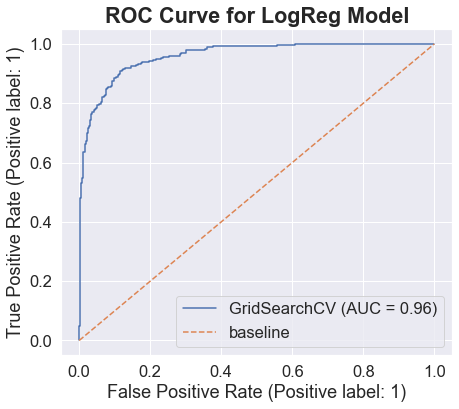

In [95]:
model = gs_logreg
title = "ROC Curve for LogReg Model"

roc_plot(model,title)

The **ROC AUC score** for this model is **0.9584**, which indicates that this model is pretty good at separating between the distributions of predictions for "Physiotherapy" vs "Chiropractic". 


### LogReg Model: Dictionary of Results

In [96]:
log_reg_dict_2 = {"transformer":"cvec","estimator":"log_reg",
                  "preprocessing": "lammetizing",
                  "gs_best_score_": gs_logreg.best_score_,
                  "gs_best_params_": gs_logreg.best_params_,
                  "train_score": gs_logreg.score(X_train_l,y_train),
                  "test_score": gs_logreg.score(X_test_l,y_test),
                  "accuracy": plot_confusion_matrix.accuracy,
                  "specificity": plot_confusion_matrix.specificity,
                  "sensitivity": plot_confusion_matrix.sensitivity,
                  "precision": plot_confusion_matrix.precision,
                  "roc_auc_score": roc_auc_log_reg}
                

In [97]:
log_reg_dict_2 = {'transformer': 'cvec',
                 'estimator': 'log_reg',
                 'preprocessing': 'lammet+extra stopwords',
                 'gs_best_score_': 0.7946472019464721,
                 'gs_best_params_': {'cvec__max_df': 0.85,
                  'cvec__max_features': 2000,
                  'cvec__min_df': 1,
                  'cvec__ngram_range': (1, 3),
                  'logreg__solver': 'liblinear',
                  'logreg__verbose': 1},
                 'train_score': 0.9805352798053528,
                 'test_score': 0.8218978102189781,
                 'accuracy': 0.8218978102189781,
                 'specificity': 0.8217522658610272,
                 'sensitivity': 0.8220338983050848,
                 'precision': 0.8314285714285714,
                 'roc_auc_score': 0.8950791131138308}

In [98]:
log_reg_dict_1 = {'transformer': 'cvec',
 'estimator': 'log_reg',
 'preprocessing': 'lammet',
 'gs_best_score_': 0.8920251340561738,
 'gs_best_params_': {'cvec__max_df': 0.85,
  'cvec__max_features': 2000,
  'cvec__min_df': 1,
  'cvec__ngram_range': (1, 3),
  'logreg__solver': 'liblinear',
  'logreg__verbose': 1},
 'train_score': 0.9931906614785992,
 'test_score': 0.892128279883382,
 'accuracy': 0.892128279883382,
 'specificity': 0.8851963746223565,
 'sensitivity': 0.8985915492957747,
 'precision': 0.8935574229691877,
 'roc_auc_score': 0.9591506744393855}

## Model 1.2: Logistic Regression and TFIDF Vectorizer

In [99]:
X_train, X_test, y_train, y_test = train_test_split(pc[['clean_text']],
                                                    pc['subreddit'],
                                                    test_size = 0.25,
                                                    random_state = 42,
                                                    stratify = pc['subreddit'])

X_train_l = [a for a in X_train["clean_text"]]
X_test_l = [b for b in X_test["clean_text"]]

### LogReg+TVEC Model: Setting up Pipelines

In [100]:
pipe_logreg_t = Pipeline([
    ('tvec',TfidfVectorizer()), #first step
    ('logreg', LogisticRegression()) #second step
])
    

In [101]:
pipe_logreg_t.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()), ('logreg', LogisticRegression())],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'logreg': LogisticRegression(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'logreg__C': 1.0,
 'logreg__class_weight': None,
 'logreg__dual': False,
 'logreg__fit_intercept': True,
 'logreg__intercept_scaling': 1,
 'logreg__l1_ratio': None,
 'logreg__max_iter': 100,
 'logreg__multi_class': 'auto',
 'logreg__n_jobs': No

In [102]:
pipe_logreg_t_params = {'tvec__max_features': [4000], #[2000,3000, 4000, 5000]
                        'tvec__min_df': [1], #[2,3]
                        'tvec__max_df': [0.85], #[0.9,0.95]
                        'tvec__ngram_range': [(1,2)], #[(1, 1)]
                        'logreg__solver': ['liblinear'],
                        'logreg__verbose': [1] #[0]
                        }

In [103]:
gs_logreg_t = GridSearchCV(pipe_logreg_t, 
                           param_grid = pipe_logreg_t_params, 
                           cv = 5) 


In [104]:
X_train_l = [a for a in X_train["clean_text"]]
X_test_l = [b for b in X_test["clean_text"]]

In [105]:
gs_logreg_t.fit(X_train_l,y_train)
gs_logreg_t.best_score_

[LibLinear]iter  1 act 4.665e+02 pre 4.332e+02 delta 1.665e+01 f 1.140e+03 |g| 6.726e+01 CG   3
iter  2 act 1.878e+01 pre 1.801e+01 delta 1.665e+01 f 6.730e+02 |g| 1.060e+01 CG   3
iter  3 act 3.190e-01 pre 3.179e-01 delta 1.665e+01 f 6.542e+02 |g| 1.234e+00 CG   4
iter  4 act 3.248e-04 pre 3.247e-04 delta 1.665e+01 f 6.539e+02 |g| 5.161e-02 CG   3
iter  5 act 3.566e-06 pre 3.566e-06 delta 1.665e+01 f 6.539e+02 |g| 4.055e-03 CG   4
[LibLinear]iter  1 act 4.646e+02 pre 4.310e+02 delta 1.659e+01 f 1.140e+03 |g| 6.716e+01 CG   3
iter  2 act 1.961e+01 pre 1.892e+01 delta 1.659e+01 f 6.756e+02 |g| 1.048e+01 CG   4
iter  3 act 1.404e-01 pre 1.385e-01 delta 1.659e+01 f 6.560e+02 |g| 9.944e-01 CG   3
iter  4 act 1.456e-03 pre 1.456e-03 delta 1.659e+01 f 6.559e+02 |g| 6.646e-02 CG   4
[LibLinear]iter  1 act 4.641e+02 pre 4.304e+02 delta 1.662e+01 f 1.140e+03 |g| 6.740e+01 CG   3
iter  2 act 1.907e+01 pre 1.828e+01 delta 1.662e+01 f 6.761e+02 |g| 1.072e+01 CG   3
iter  3 act 2.801e-01 pre 2.799e

0.8998098410223703

### LogReg+TVEC Model: Best Estimators

In [106]:
gs_logreg_t.best_estimator_[0]

TfidfVectorizer(max_df=0.85, max_features=4000, ngram_range=(1, 2))

### LogReg+TVEC Model: Train and Test Scores

In [107]:
print(f"Logistic Regression+TFIDF train score: {gs_logreg_t.score(X_train_l,y_train)}")
print(f"Logistic Regression+TFIDF test score: {gs_logreg_t.score(X_test_l,y_test)}")

Logistic Regression+TFIDF train score: 0.9693579766536965
Logistic Regression+TFIDF test score: 0.892128279883382


### LogReg+TVEC Model: Feature Coefficients

In [108]:
gs_logreg_t.best_estimator_.steps[0][1].get_feature_names_out()

array(['ab', 'ability', 'able', ..., 'yr', 'zealand', 'zero'],
      dtype=object)

In [109]:
gs_logreg_t.best_estimator_.steps[1][1].coef_

array([[ 0.07912886, -0.07436085,  0.03380943, ...,  0.38758527,
         0.1890191 , -0.07627925]])

In [110]:
log_reg_t_feat = gs_logreg_t.best_estimator_.steps[0][1].get_feature_names_out()
log_reg_t_coef = gs_logreg_t.best_estimator_.steps[1][1].coef_

logreg_t_results = pd.DataFrame(log_reg_t_coef.T,index = log_reg_t_feat)

In [111]:
logreg_t_results.columns = ["feature_coef"]

logreg_t_results.head()

,feature_coef
ab,0.079129
ability,-0.074361
able,0.033809
able get,-0.014340
able help,0.064584


In [112]:
physio_coef_t = logreg_t_results.sort_values(by = "feature_coef",ascending=False)[0:10].index

In [113]:
chiro_coef_t = logreg_t_results.sort_values(by = "feature_coef",ascending=True)[0:10].index

In [114]:
top_10_index_t = [c for c in chiro_coef_t]+[p for p in physio_coef_t]

In [115]:
logreg_t_results.to_csv("../dataset/logreg_results_t_lammet_only",index= False)

In [116]:
top_10_coef_t = logreg_t_results.loc[top_10_index,["feature_coef"]]
top_10_coef_t

,feature_coef
chiropractic,-4.641271
chiropractor,-6.138080
chiro,-3.779194
adjustment,-3.413561
cmcc,-1.885410
chiros,-1.475099
office,-1.433243
getting,-0.810735
pop,-1.193630
ray,-1.325479


### LogReg+TVEC Model: Graphical Summary of Top 10 predictor words

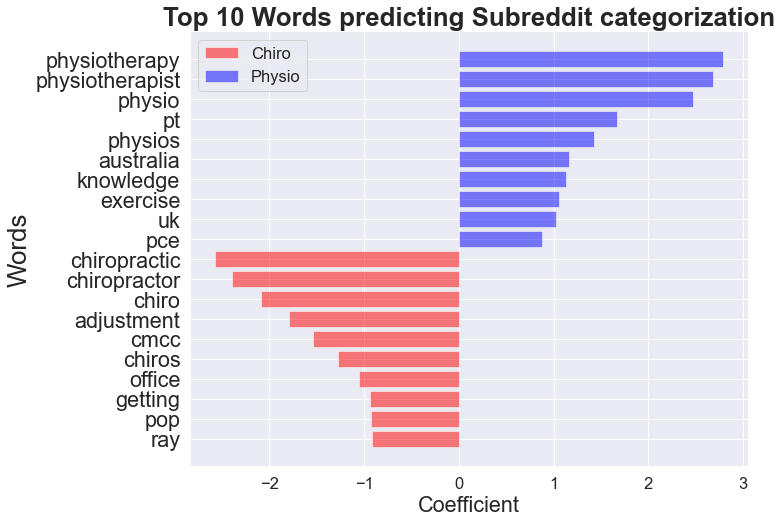

In [117]:
bar_plot(top_10,metric,x_label)

### LogReg+TVEC Model: Confusion Matrix & Performance Metrics

LogReg+TFIDF Model
------
True Negatives: 283
False Positives: 48
False Negatives: 26
True Positives: 329
-------
Accuracy = 0.892128279883382
Specificity = 0.8549848942598187
Sensitivity = 0.9267605633802817
Precision = 0.8726790450928382
--------


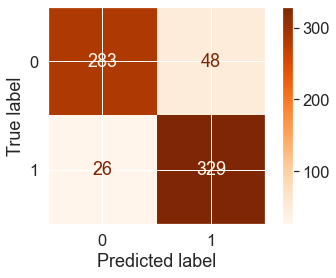

In [118]:
log_reg_t_predict = gs_logreg_t.predict(X_test_l)

predict = log_reg_t_predict
color = "Oranges"
model_name = "LogReg+TFIDF Model"

    
plot_confusion_matrix(model_name,predict,color)

### LogReg+TVEC Model Model: ROC Curve

In [119]:
roc_auc_log_reg_t = roc_auc_score(y_test,gs_logreg_t.predict_proba(X_test_l)[:,1])
roc_auc_log_reg_t

0.9616782264584486

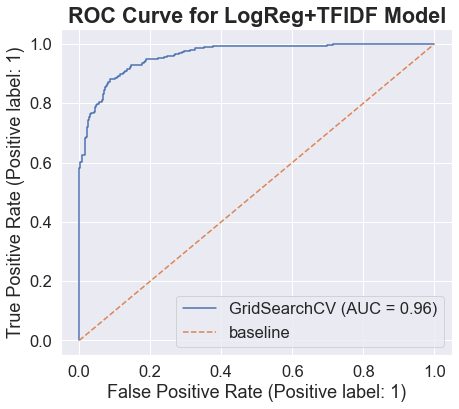

In [120]:
model = gs_logreg_t
title = "ROC Curve for LogReg+TFIDF Model"

roc_plot(model,title)

### LogReg+TFIDF Model: Dictionary of Results

In [121]:
log_reg_t_dict_2 = {"transformer":"tvec","estimator":"log_reg",
                    "preprocessing": "lammet+extra stopwords",
                    "gs_best_score_": gs_logreg_t.best_score_,
                    "gs_best_params_": gs_logreg_t.best_params_,
                    "train_score": gs_logreg_t.score(X_train_l,y_train),
                    "test_score": gs_logreg_t.score(X_test_l,y_test),
                    "accuracy": plot_confusion_matrix.accuracy,
                    "specificity": plot_confusion_matrix.specificity,
                    "sensitivity": plot_confusion_matrix.sensitivity,
                    "precision": plot_confusion_matrix.precision,
                    "roc_auc_score": roc_auc_log_reg_t}

In [122]:
log_reg_t_dict_1 = {'transformer': 'tvec',
                     'estimator': 'log_reg',
                     'preprocessing': 'lammet',
                     'gs_best_score_': 0.8998098410223703,
                     'gs_best_params_': {
                      'tvec__max_df': 0.85,
                      'tvec__max_features': 4000,
                      'tvec__min_df': 1,
                      'tvec__ngram_range': (1, 2),
                    'logreg__solver': 'liblinear',
                      'logreg__verbose': 1,},
                     'train_score': 0.9693579766536965,
                     'test_score': 0.892128279883382,
                     'accuracy': 0.892128279883382,
                     'specificity': 0.8549848942598187,
                     'sensitivity': 0.9267605633802817,
                     'precision': 0.8726790450928382,
                     'roc_auc_score': 0.9616782264584486}

In [123]:
log_reg_t_dict_2 = {'transformer': 'tvec',
                     'estimator': 'log_reg',
                     'preprocessing': 'lammet+extra stopwords',
                     'gs_best_score_': 0.8175182481751826,
                     'gs_best_params_': {
                      'tvec__max_df': 0.85,
                      'tvec__max_features': 4000,
                      'tvec__min_df': 1,
                      'tvec__ngram_range': (1, 2),
                        'logreg__solver': 'liblinear',
                      'logreg__verbose': 1,},
                     'train_score': 0.9362530413625304,
                     'test_score': 0.8306569343065694,
                     'accuracy': 0.8306569343065694,
                     'specificity': 0.7794561933534743,
                     'sensitivity': 0.8785310734463276,
                     'precision': 0.8098958333333334,
                     'roc_auc_score': 0.9121136088210696}

## Model 2: Naive Bayes and Count Vectorizer

In [124]:
X_train, X_test, y_train, y_test = train_test_split(pc[['clean_text']],
                                                    pc['subreddit'],
                                                    test_size = 0.25,
                                                    random_state = 42,
                                                    stratify = pc['subreddit'])

X_train_l = [a for a in X_train["clean_text"]]
X_test_l = [b for b in X_test["clean_text"]]

### CVEC+NB Model: Setting up Pipelines

In [125]:
pipe_cvec_nb = Pipeline([('cvec',CountVectorizer()), 
                         ('nb', MultinomialNB())])
    

In [126]:
pipe_cvec_nb.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('nb', MultinomialNB())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'nb': MultinomialNB(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True}

In [127]:
pipe_params_cvec_nb = {'cvec__max_features': [5000], #[2000, 3000, 4000]
               'cvec__min_df': [1], #[2,3]
               'cvec__max_df': [0.85], #[0.9,0.95]
               'cvec__ngram_range': [(1, 1)], #[(1,2)]

}

In [128]:
gs_cvec_nb = GridSearchCV(pipe_cvec_nb, 
                          param_grid = pipe_params_cvec_nb, 
                          cv = 5) 


In [129]:
gs_cvec_nb.fit(X_train_l,y_train)
gs_cvec_nb.best_score_

0.8706340207403208

### CVEC+NB Model: Best Estimators

In [130]:
gs_cvec_nb.best_estimator_[0]

CountVectorizer(max_df=0.85, max_features=5000)

### CVEC+NB Model: Train and Test Scores

In [131]:
print(f"cvec+Naive Bayes train score: {gs_cvec_nb.score(X_train_l,y_train)}")
print(f"cvec+Naive Bayes test score: {gs_cvec_nb.score(X_test_l,y_test)}")

cvec+Naive Bayes train score: 0.933852140077821
cvec+Naive Bayes test score: 0.8294460641399417


### CVEC+NB Model: Feature Log Probabilities

In [132]:
cvec_nb_feat = gs_cvec_nb.best_estimator_.steps[0][1].get_feature_names_out()
log_prob_0 = gs_cvec_nb.best_estimator_.steps[1][1].feature_log_prob_[0]
log_prob_1 = gs_cvec_nb.best_estimator_.steps[1][1].feature_log_prob_[1]
delta_cvec_nb = log_prob_0 - log_prob_1

cvec_nb_results = pd.DataFrame(delta_cvec_nb, index = cvec_nb_feat)


In [133]:
cvec_nb_results.columns = ["log_prob_delta"]

cvec_nb_results.head()

,log_prob_delta
aarom,-0.989786
aaron,1.495121
aastha,1.207439
ab,-0.073495
aback,1.207439


In [134]:
chiro_cvec_nb = cvec_nb_results.sort_values(by="log_prob_delta",
                                                  ascending = False).head(10)

In [135]:
physio_cvec_nb = cvec_nb_results.sort_values(by="log_prob_delta",ascending = True).head(10)

In [136]:
cvec_nb_top_10 = pd.concat([chiro_cvec_nb,physio_cvec_nb], axis=0)

In [137]:
cvec_nb_top_10

,log_prob_delta
adjustment,4.800174
chiropractic,4.350153
chiro,4.016841
atlas,4.000647
dc,3.870026
chiropractor,3.846496
denton,3.719744
doc,3.558814
cmcc,3.510024
adjusting,3.441031


### CVEC+NB Model: Graphical Summary of Top 10 Predictor Words

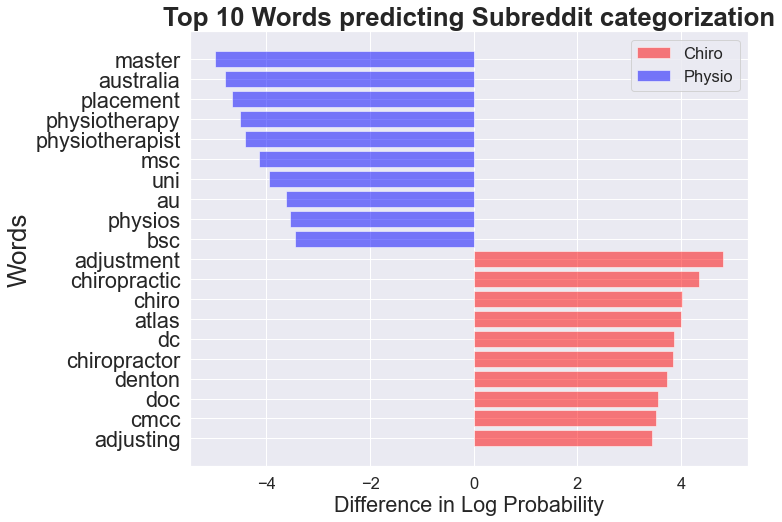

In [138]:
top_10 = cvec_nb_top_10
metric = "log_prob_delta"
x_label = "Difference in Log Probability"

bar_plot(top_10,metric,x_label)

### CVEC+NB Model: Confusion Matrix & Performance Metrics

In [139]:
cvec_nb_predict = gs_cvec_nb.predict(X_test_l)

Count Vectorizer + Naive Bayes Model
------
True Negatives: 276
False Positives: 55
False Negatives: 62
True Positives: 293
-------
Accuracy = 0.8294460641399417
Specificity = 0.8338368580060423
Sensitivity = 0.8253521126760563
Precision = 0.8419540229885057
--------


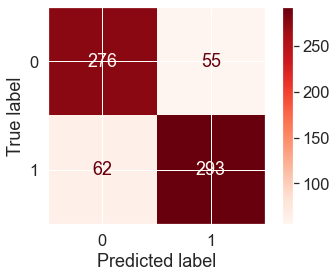

In [140]:
predict = cvec_nb_predict
color = "Reds"
model_name = "Count Vectorizer + Naive Bayes Model"

plot_confusion_matrix(model_name,predict,color)

### CVEC+NB Model: ROC Curve

In [141]:
roc_auc_cvec_nb = roc_auc_score(y_test,gs_cvec_nb.predict_proba(X_test_l)[:,1])
roc_auc_cvec_nb

0.9170333177311604

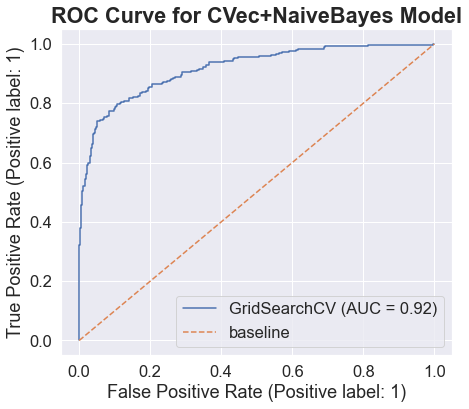

In [142]:
model = gs_cvec_nb
title = "ROC Curve for CVec+NaiveBayes Model"

roc_plot(model,title)

### CVEC+NB Model: Dictionary of Results

In [143]:
cvec_nb_dict_2 = {"transformer":"cvec","estimator":"naive_bayes",
                  "preprocessing": "lammet",
                  "gs_best_score_": gs_cvec_nb.best_score_,
                  "gs_best_params_": gs_cvec_nb.best_params_,
                  "train_score": gs_cvec_nb.score(X_train_l,y_train),
                  "test_score": gs_cvec_nb.score(X_test_l,y_test),
                  "accuracy": plot_confusion_matrix.accuracy,
                  "specificity": plot_confusion_matrix.specificity,
                  "sensitivity": plot_confusion_matrix.sensitivity,
                  "precision": plot_confusion_matrix.precision,
                  "roc_auc_score": roc_auc_cvec_nb}

In [144]:
cvec_nb_dict_1 = {'transformer': 'cvec',
 'estimator': 'naive_bayes',
 'preprocessing': 'lammet',
 'gs_best_score_': 0.8706340207403208,
 'gs_best_params_': {'cvec__max_df': 0.85,
  'cvec__max_features': 5000,
  'cvec__min_df': 1,
  'cvec__ngram_range': (1, 1)},
 'train_score': 0.933852140077821,
 'test_score': 0.8294460641399417,
 'accuracy': 0.8294460641399417,
 'specificity': 0.8338368580060423,
 'sensitivity': 0.8253521126760563,
 'precision': 0.8419540229885057,
 'roc_auc_score': 0.9170333177311604}

## Model 3: Naive Bayes and TFIDF Vectorizer

In [145]:
X_train, X_test, y_train, y_test = train_test_split(pc[['clean_text']],
                                                    pc['subreddit'],
                                                    test_size = 0.25,
                                                    random_state = 42,
                                                    stratify = pc['subreddit'])

X_train_l = [a for a in X_train["clean_text"]]
X_test_l = [b for b in X_test["clean_text"]]

### TVEC+NB Model: Setting Up Pipelines

In [146]:
pipe_tvec = Pipeline([
    ('tvec',TfidfVectorizer()), #first step
    ('nb', MultinomialNB()) #second step
])
    

In [147]:
pipe_tvec.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()), ('nb', MultinomialNB())],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'nb': MultinomialNB(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True}

In [148]:
pipe_tvec_params = {'tvec__max_features': [5000], #[2000, 3000, 4000] 
               'tvec__min_df': [1], #[2,3]
               'tvec__max_df': [0.85], #[0.9,0.95]
               'tvec__ngram_range': [(1, 1)] #[(1,2)]

}


In [149]:
gs_tvec = GridSearchCV(pipe_tvec, 
                  param_grid = pipe_tvec_params, 
                  cv = 5) 

In [150]:
# Fit GridSearch to training data.
gs_tvec.fit(X_train_l,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_df': [0.85], 'tvec__max_features': [5000],
                         'tvec__min_df': [1], 'tvec__ngram_range': [(1, 1)]})

In [151]:
gs_tvec.best_score_

0.8613894597595257

### TVEC+NB Model: Best Estimators

In [152]:
gs_tvec.best_estimator_

Pipeline(steps=[('tvec', TfidfVectorizer(max_df=0.85, max_features=5000)),
                ('nb', MultinomialNB())])

### TVEC+NB Model: Train and Test Scores

In [153]:
print(f"tvec+Naive Bayes train score: {gs_tvec.score(X_train_l,y_train)}")
print(f"tvec+Naive Bayes test score: {gs_tvec.score(X_test_l,y_test)}")


tvec+Naive Bayes train score: 0.938715953307393
tvec+Naive Bayes test score: 0.8279883381924198


### TVEC+NB Model: Feature Log Probabilities

In [154]:
tvec_nb_feat = gs_tvec.best_estimator_.steps[0][1].get_feature_names_out()
log_prob_0_t = gs_tvec.best_estimator_.steps[1][1].feature_log_prob_[0]
log_prob_1_t = gs_tvec.best_estimator_.steps[1][1].feature_log_prob_[1]
delta_tvec_nb = log_prob_0_t - log_prob_1_t

tvec_nb_results = pd.DataFrame(delta_tvec_nb, index = tvec_nb_feat)
tvec_nb_results.columns = ["log_prob_delta"]

tvec_nb_results.head()

,log_prob_delta
aarom,-0.220173
aaron,0.659278
aastha,0.657640
ab,-0.030321
aback,0.225384


In [155]:
chiro_tvec_nb = tvec_nb_results.sort_values(by="log_prob_delta",
                                            ascending = False).head(10)
physio_tvec_nb = tvec_nb_results.sort_values(by="log_prob_delta",
                                             ascending = True).head(10)
tvec_nb_top_10 = pd.concat([chiro_tvec_nb,physio_tvec_nb], axis=0)

tvec_nb_top_10

,log_prob_delta
adjustment,3.357594
chiropractor,3.338935
chiropractic,3.223062
denton,2.936888
chiro,2.738648
relief,2.433564
atlas,2.125077
table,2.101249
neck,2.025686
crack,2.004285


### TVEC+NB Model: Graphical Summary of Top 10 Predictor Words

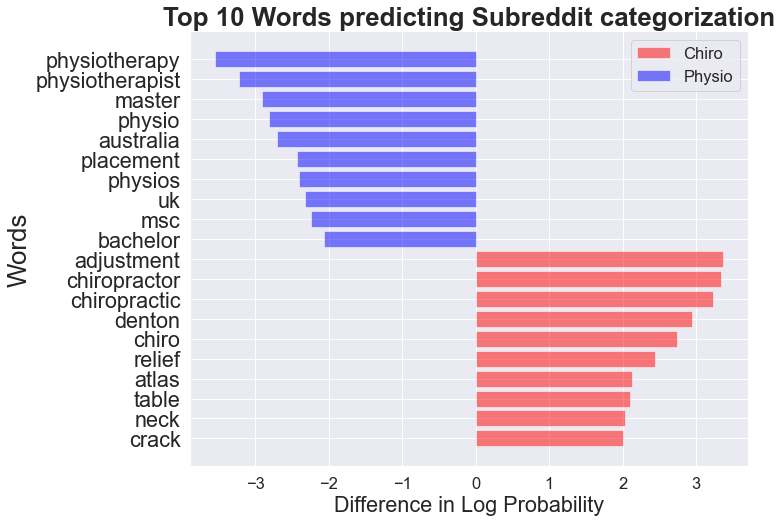

In [156]:
top_10 = tvec_nb_top_10
metric = "log_prob_delta"
x_label = "Difference in Log Probability"

bar_plot(top_10,metric,x_label)

### TVEC+NB Model: Confusion Matrix & Performance Metrics

In [157]:
tvec_nb_predict = gs_tvec.predict(X_test_l)

TFIDF Vectorizer + Naive Bayes Model
------
True Negatives: 270
False Positives: 61
False Negatives: 57
True Positives: 298
-------
Accuracy = 0.8279883381924198
Specificity = 0.8157099697885196
Sensitivity = 0.8394366197183099
Precision = 0.83008356545961
--------


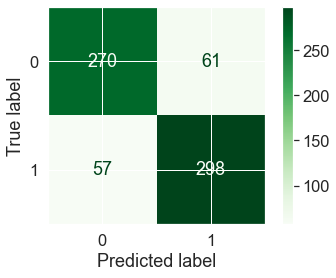

In [158]:
predict = tvec_nb_predict
color = "Greens"
model_name = "TFIDF Vectorizer + Naive Bayes Model"

plot_confusion_matrix(model_name,predict,color)

### TVEC+NB Model: ROC Curve

In [159]:
roc_auc_tvec_nb = roc_auc_score(y_test,gs_tvec.predict_proba(X_test_l)[:,1])
roc_auc_tvec_nb

0.9268541764180248

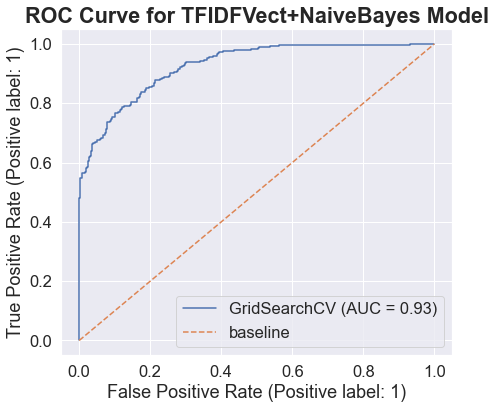

In [160]:
model = gs_tvec
title = "ROC Curve for TFIDFVect+NaiveBayes Model"

roc_plot(model,title)

### TVEC+NB Model: Dictionary of Results

In [161]:
tvec_nb_dict_2 = {"transformer":"tvec","estimator":"naive_bayes",
                  "preprocessing": "lammet",
                  "gs_best_score_": gs_tvec.best_score_,
                  "gs_best_params_": gs_tvec.best_params_,
                  "train_score": gs_tvec.score(X_train_l,y_train),
                  "test_score": gs_tvec.score(X_test_l,y_test),
                  "accuracy": plot_confusion_matrix.accuracy,
                  "specificity": plot_confusion_matrix.specificity,
                  "sensitivity": plot_confusion_matrix.sensitivity,
                  "precision": plot_confusion_matrix.precision,
                  "roc_auc_score": roc_auc_tvec_nb}

In [162]:
tvec_nb_dict_1 = {'transformer': 'tvec',
 'estimator': 'naive_bayes',
 'preprocessing': 'lammet',
 'gs_best_score_': 0.8613894597595257,
 'gs_best_params_': {'tvec__max_df': 0.85,
  'tvec__max_features': 5000,
  'tvec__min_df': 1,
  'tvec__ngram_range': (1, 1)},
 'train_score': 0.938715953307393,
 'test_score': 0.8279883381924198,
 'accuracy': 0.8279883381924198,
 'specificity': 0.8157099697885196,
 'sensitivity': 0.8394366197183099,
 'precision': 0.83008356545961,
 'roc_auc_score': 0.9268541764180248 }

## Model 4: Random Forest Classifier and Count Vectorizer

### CVEC+Random Forest Model: Setting Up Pipelines

In [163]:
X_train, X_test, y_train, y_test = train_test_split(pc[['clean_text']],
                                                    pc['subreddit'],
                                                    test_size = 0.25,
                                                    random_state = 42,
                                                    stratify = pc['subreddit'])

X_train_l = [a for a in X_train["clean_text"]]
X_test_l = [b for b in X_test["clean_text"]]

In [164]:
pipe_rf = Pipeline([
    ('cvec',CountVectorizer()), #first step
    ('rf', RandomForestClassifier()) #second step
])
    

In [165]:
pipe_rf.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('rf', RandomForestClassifier())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'rf': RandomForestClassifier(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_est

In [166]:
rf_params = {
    'rf__n_estimators': [300], #[100, 150, 200]
    'rf__random_state': [42],
    'rf__max_depth': [None], #[1,2,3,4,5]
    'cvec__max_features': [4000], #[2000, 3000, 5000]
    'cvec__ngram_range': [(1,2)], #[(1, 1)]
}


In [167]:
gs_rf = GridSearchCV(pipe_rf, param_grid=rf_params, cv=5)
gs_rf.fit(X_train_l, y_train)
print(gs_rf.best_score_)
gs_rf.best_params_

0.8920227718328491


{'cvec__max_features': 4000,
 'cvec__ngram_range': (1, 2),
 'rf__max_depth': None,
 'rf__n_estimators': 300,
 'rf__random_state': 42}

### CVEC+Random Forest Model: Best Estimators

In [168]:
gs_rf.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(max_features=4000, ngram_range=(1, 2))),
                ('rf',
                 RandomForestClassifier(n_estimators=300, random_state=42))])

### CVEC+Random Forest Model: Train and Test Scores

In [169]:
print(f"cvec+RF train score: {gs_rf.score(X_train_l,y_train)}")
print(f"cvec+RF test score: {gs_rf.score(X_test_l,y_test)}")


cvec+RF train score: 0.9995136186770428
cvec+RF test score: 0.8848396501457726


### CVEC+Random Forest Model: Feature Importance

In [170]:
rf_feat = gs_rf.best_estimator_.steps[0][1].get_feature_names_out()
rf_feat_importance = gs_rf.best_estimator_.steps[1][1].feature_importances_
# delta_tvec_nb = log_prob_0_t - log_prob_1_t

rf_results = pd.DataFrame(rf_feat_importance, index = rf_feat)
rf_results.columns = ["feat_importance"]

rf_results.head()

,feat_importance
ab,0.000089
ability,0.000074
able,0.000622
able get,0.000034
able help,0.000068


In [171]:
rf_top_20 = rf_results.sort_values(by="feat_importance",ascending = False).head(20)
rf_top_20

,feat_importance
chiropractor,0.056409
physiotherapy,0.046462
physio,0.036075
chiropractic,0.028044
physiotherapist,0.027764
adjustment,0.020560
chiro,0.018088
uk,0.012738
neck,0.012488
back,0.011011


### CVEC+Random Forest Model: Graphical Summary of Top 10 Predictor Words

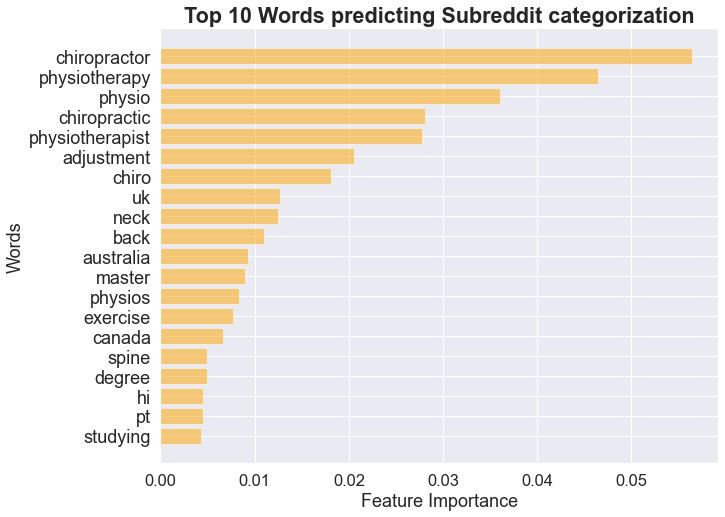

In [172]:
top_10 = rf_top_20
metric = "feat_importance"
x_label = "Feature Importance"

def bar_plot_uni(top_10,metric,x_label):
    plt.figure(figsize = (10,8))
    plt.barh(top_10.index[::-1],top_10[metric][::-1],
             color = "orange",alpha=0.5)

    plt.yticks(fontsize="medium")
    plt.xlabel(x_label,fontsize="medium")
    plt.ylabel("Words",fontsize="medium")
    plt.title("Top 10 Words predicting Subreddit categorization",fontsize="large",fontweight="heavy");

bar_plot_uni(top_10,metric,x_label)

### CVEC+Random Forest Model: Confusion Matrix & Performance Metrics

In [173]:
rf_predict = gs_rf.predict(X_test_l)

Count Vectorizer + Random Forests Model
------
True Negatives: 278
False Positives: 53
False Negatives: 26
True Positives: 329
-------
Accuracy = 0.8848396501457726
Specificity = 0.8398791540785498
Sensitivity = 0.9267605633802817
Precision = 0.8612565445026178
--------


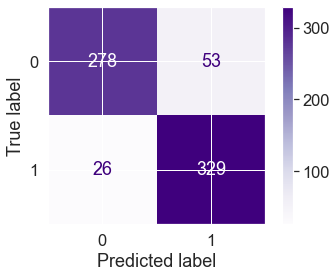

In [174]:
predict = rf_predict
color = "Purples"
model_name = "Count Vectorizer + Random Forests Model"

plot_confusion_matrix(model_name,predict,color)


### CVEC+Random Forest Model: ROC Curve

In [175]:
roc_auc_rf = roc_auc_score(y_test,gs_rf.predict_proba(X_test_l)[:,1])
roc_auc_rf

0.955044466192928

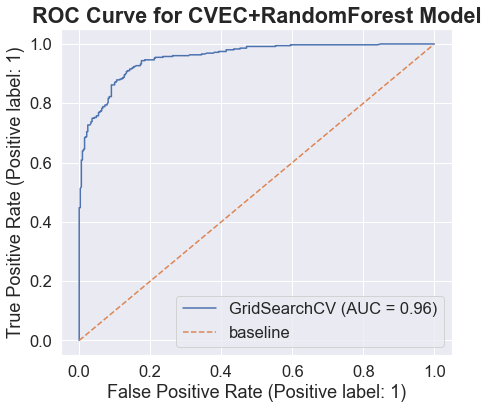

In [176]:
model = gs_rf
title = "ROC Curve for CVEC+RandomForest Model"

roc_plot(model,title)

### CVEC+Random Forest Model: Dictionary of Results

In [177]:
rf_dict_2 = {"transformer":"cvec","estimator":"random_forest",
             "preprocessing": "lammet",
             "gs_best_score_": gs_rf.best_score_,
             "gs_best_params_": gs_rf.best_params_,
             "train_score": gs_rf.score(X_train_l,y_train),
             "test_score": gs_rf.score(X_test_l,y_test),
             "accuracy": plot_confusion_matrix.accuracy,
             "specificity": plot_confusion_matrix.specificity,
             "sensitivity": plot_confusion_matrix.sensitivity,
             "precision": plot_confusion_matrix.precision,
             "roc_auc_score": roc_auc_rf}

In [178]:
rf_dict_1 = {'transformer': 'cvec',
 'estimator': 'random_forest',
 'preprocessing': 'lammet',
 'gs_best_score_': 0.8920227718328491,
 'gs_best_params_': {'cvec__max_features': 4000,
  'cvec__ngram_range': (1, 2),
  'rf__max_depth': None,
  'rf__n_estimators': 300,
  'rf__random_state': 42},
 'train_score': 0.9995136186770428,
 'test_score': 0.8848396501457726,
 'accuracy': 0.8848396501457726,
 'specificity': 0.8398791540785498,
 'sensitivity': 0.9267605633802817,
 'precision': 0.8612565445026178,
 'roc_auc_score': 0.955044466192928}

## 5.2. Table of Results

In [179]:
compile_dict = []

In [180]:
for i in [log_reg_dict_1,log_reg_dict_2,log_reg_t_dict_1,log_reg_t_dict_2,
          tvec_nb_dict_1,cvec_nb_dict_1,rf_dict_1]:
    compile_dict.append(i)

In [181]:
dicts = pd.DataFrame(compile_dict)

In [182]:
dicts

,transformer,estimator,preprocessing,gs_best_score_,gs_best_params_,train_score,test_score,accuracy,specificity,sensitivity,precision,roc_auc_score
0,cvec,log_reg,lammet,0.892025,"{'cvec__max_df': 0.85, 'cvec__max_features': 2...",0.993191,0.892128,0.892128,0.885196,0.898592,0.893557,0.959151
1,cvec,log_reg,lammet+extra stopwords,0.794647,"{'cvec__max_df': 0.85, 'cvec__max_features': 2...",0.980535,0.821898,0.821898,0.821752,0.822034,0.831429,0.895079
2,tvec,log_reg,lammet,0.899810,"{'tvec__max_df': 0.85, 'tvec__max_features': 4...",0.969358,0.892128,0.892128,0.854985,0.926761,0.872679,0.961678
3,tvec,log_reg,lammet+extra stopwords,0.817518,"{'tvec__max_df': 0.85, 'tvec__max_features': 4...",0.936253,0.830657,0.830657,0.779456,0.878531,0.809896,0.912114
4,tvec,naive_bayes,lammet,0.861389,"{'tvec__max_df': 0.85, 'tvec__max_features': 5...",0.938716,0.827988,0.827988,0.815710,0.839437,0.830084,0.926854
5,cvec,naive_bayes,lammet,0.870634,"{'cvec__max_df': 0.85, 'cvec__max_features': 5...",0.933852,0.829446,0.829446,0.833837,0.825352,0.841954,0.917033
6,cvec,random_forest,lammet,0.892023,"{'cvec__max_features': 4000, 'cvec__ngram_rang...",0.999514,0.884840,0.884840,0.839879,0.926761,0.861257,0.955044


***Note:*** In rows 1 and 3 above, "extra stopwords" refers to the process of removing words that are very closely related to "Physiotherapy" and "Chiropractic", ie: "Physiotherapist", "Physios", "Physio", "Chiros", "Chiro", etc. 

## 6. Conclusion

**Hypothesis Testing:**

- Based on the multiple models tested above, it is possible to successfully classify posts into "Physiotherapy" and "Chiropractic" with reasonable accuracy. This means there is a strong relationship between a particular class, and the occurence of certain words in it. 

- Hence, we reject the null hypothesis and accept the null hypothesis. 

**Best Classification Model:**

- For the time being, among the 7 models tested, the model of choice is the Logistic Regression model coupled to a Count Vectorizer. It has the highest accuracy score, and is rather well balanced across the other performance metrics: specificity, sensitivity, precision and ROC AUC Score.  

- The Logistic Regression model coupled to a TFIDF Vectorizer (Model 3) is the next best choice. It has the same Accuracy as our first choice, but beats it in terms of sensitivity and ROC AUC Score. However, it sacrifices some degree of specificity and sensitivity. 

- As our goal is to correctly classify BOTH classes to retrieve the most amount of correct and useful information for our client, it is equally bad to predict either class incorrectly. In other words, it does not make sense to reduce False Positives or False Negatives in favor of either. Hence, we chose Model 1, which is more well-rounded in terms of performance metrics compared to Model 3. 

In [183]:
dicts.iloc[[0,2],[0,1,2,7,8,9,10,11]]

,transformer,estimator,preprocessing,accuracy,specificity,sensitivity,precision,roc_auc_score
0,cvec,log_reg,lammet,0.892128,0.885196,0.898592,0.893557,0.959151
2,tvec,log_reg,lammet,0.892128,0.854985,0.926761,0.872679,0.961678


**Impact of removing "obvious" words:**:

- Variations of the words "physio" and "chiro" appear as top predictor words in all models. 

- If we remove these "obvious" words from the dataset, performance drops across all metrics. However, the model is still able to perform rather successfully at classifying posts, with an accuracy of 82% (well-above the baseline score of 51%). 


In [184]:
dicts.iloc[[0,1],[0,1,2,7,8,9,10,11]]

,transformer,estimator,preprocessing,accuracy,specificity,sensitivity,precision,roc_auc_score
0,cvec,log_reg,lammet,0.892128,0.885196,0.898592,0.893557,0.959151
1,cvec,log_reg,lammet+extra stopwords,0.821898,0.821752,0.822034,0.831429,0.895079


**Insights:**

- Based on the NLP models created above, we have identified words that set "Physio" apart from "Chiro", mainly: "exercise" (which is more relevant to "physio"), and "adjustment" (which is more relevant to "chiro"). 

- For the purpose of education, we have also discovered that those aspiring to be Physiotherapists need to graduate with a Bachelor's or Master's degree, and pass the PCE (Physiotherapy Competency Examination). On the other hand, those who wish to practice Chiropractic Care need to get a degree in Doctor of Chiropractic. Education options include the Canadian Memorial Chiropractic College (CMCC).

## 7. Proposed Future Works:

It makes sense to further fine-tune model 2 (CVEC+Logistic Regression Model, with variations of "physio" or "chiro" removed). This can be done by:

- Scraping extra data to further train the model. Besides referring to Subreddit posts, we can refer to other sources of data related to the two topics (eg: websites of hospitals and physiotherapy/chiropractic clinics)

- Additional Hyperparameter tuning